# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844



In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
 # change to your folder directory
# %cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
%cd "/content/drive/MyDrive/EE247_FinalProject/project"


Mounted at /content/drive
/content/drive/MyDrive/EE247_FinalProject/project


In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Collecting the data for subject 1
#person_train = np.squeeze(person_train_valid, -1)
#person_test = np.squeeze(person_test, -1)
train_ind = np.where(person_train_valid == 1)[0]
test_ind = np.where(person_test == 1)[0]
X_test_subject_1 = X_test[test_ind]
y_test_subject_1 = y_test[test_ind]
X_train_valid_subject_1 = X_train_valid[train_ind]
y_train_valid_subject_1 = y_train_valid[train_ind]

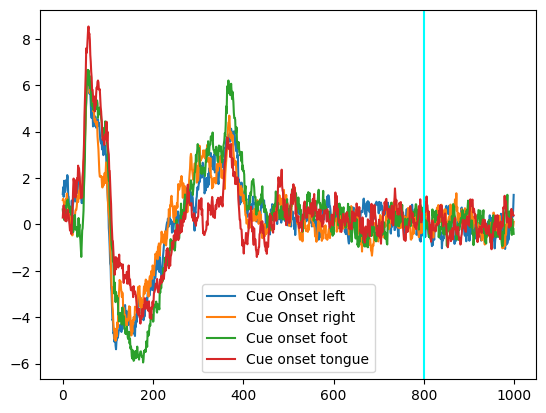

In [4]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
y_train_valid_subject_1 -= 769
y_test_subject_1 -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [5]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y




def val_test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [6]:
def data_loader(X_train_valid, y_train_valid, model_choice="CNN"):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv
    elif model_choice == "EEGNet":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])     # EEGNet; add extra dim for 2D conv

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv
    elif model_choice == "EEGNet":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])

    # print("My training data: ", train_data_aug.shape)
    # print("My training label: ", train_label_aug.shape)
    # print()
    # print("My val data: ", val_data_aug.shape)
    # print("My val label: ", val_label.shape)
    # print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data

    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [7]:
np.random.seed(247)
x_train_sub_1, y_train_sub_1, x_valid_sub_1, y_valid_sub_1 = data_loader(X_train_valid_subject_1, y_train_valid_subject_1, model_choice="CNN")
x_train_CNN, y_train_CNN, x_valid_CNN, y_valid_CNN = data_loader(X_train_valid, y_train_valid, model_choice="CNN")
x_train_sub_1_EEG, y_train_sub_1_EEG, x_valid_sub_1_EEG, y_valid_sub_1_EEG = data_loader(X_train_valid_subject_1, y_train_valid_subject_1, model_choice="EEGNet")
x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG= data_loader(X_train_valid, y_train_valid, model_choice="EEGNet")

In [8]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [9]:
###################################################################################
## Training Function ##############################################################
###################################################################################

np.random.seed(247)
torch.manual_seed(147)

def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [10]:
###################################################################################
## Testing Function ##############################################################
###################################################################################

def test_model(model, model_choice="LSTM", X_test=X_test, y_test=y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test)

    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN" or model_choice == "CLSTM":
            x_test = x_test.unsqueeze(-1)
        elif model_choice == "EEGNet":
            x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", model_choice, "is: ", test_acc)



# **MODEL DEFINITION**





> Here, we define the models used in this second experiment. Our models are:
1.   CNN
2.   EEG NET


In [11]:
###################################################################################
## Classification with a CNN #####################################################
###################################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Block 1
        layers=[]
        layers.append(nn.Conv2d(in_channels=22, out_channels=25, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(25))
        layers.append(nn.Dropout(p=0.6))

        # Block 2
        layers.append(nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(50))
        layers.append(nn.Dropout(p=0.6))


        # Block 3
        layers.append(nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        layers.append(nn.BatchNorm2d(100))
        layers.append(nn.Dropout(p=0.6))


        # Block 3
        layers.append(nn.Conv2d(in_channels=100, out_channels=200, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), stride=(3,1)))
        layers.append(nn.BatchNorm2d(200))
        layers.append(nn.Dropout(p=0.6))

        # FC Layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(1000,40))
        layers.append(nn.Linear(40,10))
        layers.append(nn.Linear(10,4))
        self.model_nn = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model_nn:
            x = layer(x)

        return x


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
summary(cnn, input_size=x_train_CNN[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 25, 400, 1]          13,775
│    └─ELU: 2-2                          [64, 25, 400, 1]          --
│    └─MaxPool2d: 2-3                    [64, 25, 134, 1]          --
│    └─BatchNorm2d: 2-4                  [64, 25, 134, 1]          50
│    └─Dropout: 2-5                      [64, 25, 134, 1]          --
│    └─Conv2d: 2-6                       [64, 50, 134, 1]          31,300
│    └─ELU: 2-7                          [64, 50, 134, 1]          --
│    └─MaxPool2d: 2-8                    [64, 50, 45, 1]           --
│    └─BatchNorm2d: 2-9                  [64, 50, 45, 1]           100
│    └─Dropout: 2-10                     [64, 50, 45, 1]           --
│    └─Conv2d: 2-11                      [64, 100, 45, 1]          125,100
│

In [13]:
##################################################################################
## Classification with an EEG Net ################################################
##################################################################################
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        layers=[]
        """
        block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                    input_shape = (Chans, Samples, 1),
                                    use_bias = False)(input1)
        block1       = BatchNormalization()(block1)
        block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                    depth_multiplier = D,
                                    depthwise_constraint = max_norm(1.))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('elu')(block1)
        block1       = AveragePooling2D((1, 4))(block1)
        block1       = dropoutType(dropoutRate)(block1)
        """
        num_classes=4
        num_channel = 22
        num_sample = 400
        fs = 250
        dropoutRate = 0.25
        filter_len = fs//2
        F1 = 8
        D = 2
        F2 = 16
        norm_rate = 0.25

        layers = []
        # Block 1
        # Input shape: N*1*C*T
        layers.append(nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=[1, filter_len], padding='same', bias=False))
        layers.append(nn.BatchNorm2d(num_features=F1))
        layers.append(ConstrainedConv2d(in_channels=F1, out_channels=D*F1, groups=F1, kernel_size=[num_channel, 1], padding='valid', bias=False))
        layers.append(nn.BatchNorm2d(num_features=D*F1))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,4]))
        layers.append(nn.Dropout(dropoutRate))

        #Block2
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=D*F1, groups=D*F1, kernel_size=[1, filter_len//2], padding="same"))
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=1))
        layers.append(nn.BatchNorm2d(num_features=F2))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,8]))
        layers.append(nn.Dropout(dropoutRate))
        layers.append(nn.Flatten())
        # layers.append(nn.LSTM(input_size=192, hidden_size=10, num_layers=1, dropout=0.4))
        layers.append(nn.Linear(in_features=192, out_features=num_classes))
        self.model = nn.ModuleList(layers)


    def forward(self, x):
        for layer in self.model:
            x = layer(x)
            if type(x) == tuple:
                x = x[0]
        return x

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eegnet = EEGNet().to(device)
summary(eegnet, input_size=x_train_EEG[0:64].shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 8, 22, 400]          1,000
│    └─BatchNorm2d: 2-2                  [64, 8, 22, 400]          16
│    └─ConstrainedConv2d: 2-3            [64, 16, 1, 400]          352
│    └─BatchNorm2d: 2-4                  [64, 16, 1, 400]          32
│    └─ELU: 2-5                          [64, 16, 1, 400]          --
│    └─AvgPool2d: 2-6                    [64, 16, 1, 100]          --
│    └─Dropout: 2-7                      [64, 16, 1, 100]          --
│    └─Conv2d: 2-8                       [64, 16, 1, 100]          1,008
│    └─Conv2d: 2-9                       [64, 16, 1, 100]          272
│    └─BatchNorm2d: 2-10                 [64, 16, 1, 100]          32
│    └─ELU: 2-11                         [64, 16, 1, 100]          --
│    └─

# **Training Our Models**

> We have three training modes. They are:
1.   First, we will train our models on all the data sets and test them on all subjects
2.   Second, we will train our models on all the data sets and test them on subject 1
3.   Third, we will train our models on subject 1 and test them on subject 1

In [15]:
###################################################################################
## No (1) Training and Test The CNN ###############################################
###################################################################################
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data_cnn = {
    "x_train": x_train_CNN,
    "y_train": y_train_CNN,
    "x_valid": x_valid_CNN,
    "y_valid": y_valid_CNN
}
training_acc_CNN, validation_acc_CNN = train_model(data_cnn, optimizer, criterion, cnn, batch_size, num_epoch)
start_time = time.time()
test_model(cnn, model_choice="CNN", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CNN(
  (model_nn): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.413
[1, 52] loss: 1.383
[1, 78] loss: 1.363


  2%|▏         | 1/60 [00:02<02:23,  2.43s/it]

[1, 104] loss: 1.342
Validation Accuracy: 0.2978723347187042
Epoch:  2
[2, 26] loss: 1.324
[2, 52] loss: 1.305
[2, 78] loss: 1.256


  3%|▎         | 2/60 [00:03<01:49,  1.89s/it]

[2, 104] loss: 1.237
Validation Accuracy: 0.47754135727882385
Epoch:  3
[3, 26] loss: 1.208
[3, 52] loss: 1.201
[3, 78] loss: 1.175


  5%|▌         | 3/60 [00:05<01:38,  1.72s/it]

[3, 104] loss: 1.177
Validation Accuracy: 0.5035461187362671
Epoch:  4
[4, 26] loss: 1.130
[4, 52] loss: 1.130
[4, 78] loss: 1.141


  7%|▋         | 4/60 [00:07<01:32,  1.65s/it]

[4, 104] loss: 1.127
Validation Accuracy: 0.5390070676803589
Epoch:  5
[5, 26] loss: 1.069
[5, 52] loss: 1.052
[5, 78] loss: 1.097


  8%|▊         | 5/60 [00:08<01:28,  1.61s/it]

[5, 104] loss: 1.048
Validation Accuracy: 0.5413711667060852
Epoch:  6
[6, 26] loss: 1.065
[6, 52] loss: 1.045
[6, 78] loss: 1.031


 10%|█         | 6/60 [00:10<01:25,  1.59s/it]

[6, 104] loss: 1.067
Validation Accuracy: 0.567375898361206
Epoch:  7
[7, 26] loss: 1.028
[7, 52] loss: 1.046
[7, 78] loss: 0.987


 12%|█▏        | 7/60 [00:11<01:23,  1.57s/it]

[7, 104] loss: 1.014
Validation Accuracy: 0.5650117993354797
Epoch:  8
[8, 26] loss: 1.004
[8, 52] loss: 0.972
[8, 78] loss: 0.990


 13%|█▎        | 8/60 [00:13<01:21,  1.57s/it]

[8, 104] loss: 0.984
Validation Accuracy: 0.5957446694374084
Epoch:  9
[9, 26] loss: 0.947
[9, 52] loss: 0.919
[9, 78] loss: 0.978


 15%|█▌        | 9/60 [00:14<01:19,  1.57s/it]

[9, 104] loss: 0.986
Validation Accuracy: 0.6028369069099426
Epoch:  10
[10, 26] loss: 0.951
[10, 52] loss: 0.971
[10, 78] loss: 0.908


 17%|█▋        | 10/60 [00:16<01:18,  1.56s/it]

[10, 104] loss: 0.915
Validation Accuracy: 0.6122931241989136
Epoch:  11
[11, 26] loss: 0.919
[11, 52] loss: 0.887
[11, 78] loss: 0.932


 18%|█▊        | 11/60 [00:17<01:16,  1.56s/it]

[11, 104] loss: 0.917
Validation Accuracy: 0.6453900933265686
Epoch:  12
[12, 26] loss: 0.906
[12, 52] loss: 0.900
[12, 78] loss: 0.885


 20%|██        | 12/60 [00:19<01:15,  1.56s/it]

[12, 104] loss: 0.888
Validation Accuracy: 0.6193853616714478
Epoch:  13
[13, 26] loss: 0.909
[13, 52] loss: 0.837
[13, 78] loss: 0.858


 22%|██▏       | 13/60 [00:21<01:13,  1.57s/it]

[13, 104] loss: 0.881
Validation Accuracy: 0.6453900933265686
Epoch:  14
[14, 26] loss: 0.864
[14, 52] loss: 0.899
[14, 78] loss: 0.885


 23%|██▎       | 14/60 [00:22<01:12,  1.57s/it]

[14, 104] loss: 0.833
Validation Accuracy: 0.6595744490623474
Epoch:  15
[15, 26] loss: 0.831
[15, 52] loss: 0.894
[15, 78] loss: 0.857


 25%|██▌       | 15/60 [00:24<01:10,  1.57s/it]

[15, 104] loss: 0.854
Validation Accuracy: 0.6572104096412659
Epoch:  16
[16, 26] loss: 0.812
[16, 52] loss: 0.846
[16, 78] loss: 0.799


 27%|██▋       | 16/60 [00:25<01:09,  1.57s/it]

[16, 104] loss: 0.855
Validation Accuracy: 0.6595744490623474
Epoch:  17
[17, 26] loss: 0.805
[17, 52] loss: 0.858
[17, 78] loss: 0.823


 28%|██▊       | 17/60 [00:27<01:07,  1.57s/it]

[17, 104] loss: 0.823
Validation Accuracy: 0.6335697174072266
Epoch:  18
[18, 26] loss: 0.809
[18, 52] loss: 0.823
[18, 78] loss: 0.800


 30%|███       | 18/60 [00:28<01:06,  1.58s/it]

[18, 104] loss: 0.831
Validation Accuracy: 0.6382978558540344
Epoch:  19
[19, 26] loss: 0.794
[19, 52] loss: 0.817
[19, 78] loss: 0.790


 32%|███▏      | 19/60 [00:30<01:04,  1.58s/it]

[19, 104] loss: 0.816
Validation Accuracy: 0.6453900933265686
Epoch:  20
[20, 26] loss: 0.809
[20, 52] loss: 0.780
[20, 78] loss: 0.790


 33%|███▎      | 20/60 [00:32<01:03,  1.59s/it]

[20, 104] loss: 0.809
Validation Accuracy: 0.6288415789604187
Epoch:  21
[21, 26] loss: 0.771
[21, 52] loss: 0.787
[21, 78] loss: 0.776


 35%|███▌      | 21/60 [00:33<01:02,  1.59s/it]

[21, 104] loss: 0.824
Validation Accuracy: 0.652482271194458
Epoch:  22
[22, 26] loss: 0.752
[22, 52] loss: 0.774
[22, 78] loss: 0.777


 37%|███▋      | 22/60 [00:35<01:00,  1.60s/it]

[22, 104] loss: 0.789
Validation Accuracy: 0.6666666865348816
Epoch:  23
[23, 26] loss: 0.745
[23, 52] loss: 0.756
[23, 78] loss: 0.774


 38%|███▊      | 23/60 [00:36<00:59,  1.60s/it]

[23, 104] loss: 0.762
Validation Accuracy: 0.6690307259559631
Epoch:  24
[24, 26] loss: 0.751
[24, 52] loss: 0.771
[24, 78] loss: 0.762


 40%|████      | 24/60 [00:38<00:57,  1.60s/it]

[24, 104] loss: 0.765
Validation Accuracy: 0.652482271194458
Epoch:  25
[25, 26] loss: 0.726
[25, 52] loss: 0.724
[25, 78] loss: 0.750


 42%|████▏     | 25/60 [00:40<00:56,  1.61s/it]

[25, 104] loss: 0.738
Validation Accuracy: 0.6643025875091553
Epoch:  26
[26, 26] loss: 0.736
[26, 52] loss: 0.747
[26, 78] loss: 0.739


 43%|████▎     | 26/60 [00:41<00:54,  1.61s/it]

[26, 104] loss: 0.709
Validation Accuracy: 0.6903073191642761
Epoch:  27
[27, 26] loss: 0.731
[27, 52] loss: 0.729
[27, 78] loss: 0.729


 45%|████▌     | 27/60 [00:43<00:53,  1.61s/it]

[27, 104] loss: 0.735
Validation Accuracy: 0.6690307259559631
Epoch:  28
[28, 26] loss: 0.698
[28, 52] loss: 0.721
[28, 78] loss: 0.711


 47%|████▋     | 28/60 [00:45<00:51,  1.62s/it]

[28, 104] loss: 0.717
Validation Accuracy: 0.6713948249816895
Epoch:  29
[29, 26] loss: 0.691
[29, 52] loss: 0.736
[29, 78] loss: 0.695


 48%|████▊     | 29/60 [00:46<00:50,  1.63s/it]

[29, 104] loss: 0.726
Validation Accuracy: 0.6713948249816895
Epoch:  30
[30, 26] loss: 0.741
[30, 52] loss: 0.692
[30, 78] loss: 0.723


 50%|█████     | 30/60 [00:48<00:49,  1.64s/it]

[30, 104] loss: 0.725
Validation Accuracy: 0.6666666865348816
Epoch:  31
[31, 26] loss: 0.698
[31, 52] loss: 0.702
[31, 78] loss: 0.739


 52%|█████▏    | 31/60 [00:49<00:47,  1.64s/it]

[31, 104] loss: 0.722
Validation Accuracy: 0.695035457611084
Epoch:  32
[32, 26] loss: 0.728
[32, 52] loss: 0.700
[32, 78] loss: 0.717


 53%|█████▎    | 32/60 [00:51<00:45,  1.64s/it]

[32, 104] loss: 0.686
Validation Accuracy: 0.6879432797431946
Epoch:  33
[33, 26] loss: 0.661
[33, 52] loss: 0.728
[33, 78] loss: 0.712


 55%|█████▌    | 33/60 [00:53<00:44,  1.64s/it]

[33, 104] loss: 0.710
Validation Accuracy: 0.6903073191642761
Epoch:  34
[34, 26] loss: 0.697
[34, 52] loss: 0.667
[34, 78] loss: 0.684


 57%|█████▋    | 34/60 [00:54<00:42,  1.64s/it]

[34, 104] loss: 0.708
Validation Accuracy: 0.6855791807174683
Epoch:  35
[35, 26] loss: 0.671
[35, 52] loss: 0.673
[35, 78] loss: 0.654


 58%|█████▊    | 35/60 [00:56<00:40,  1.64s/it]

[35, 104] loss: 0.696
Validation Accuracy: 0.6879432797431946
Epoch:  36
[36, 26] loss: 0.695
[36, 52] loss: 0.717
[36, 78] loss: 0.663


 60%|██████    | 36/60 [00:58<00:39,  1.64s/it]

[36, 104] loss: 0.685
Validation Accuracy: 0.6832151412963867
Epoch:  37
[37, 26] loss: 0.676
[37, 52] loss: 0.642
[37, 78] loss: 0.699


 62%|██████▏   | 37/60 [00:59<00:38,  1.66s/it]

[37, 104] loss: 0.661
Validation Accuracy: 0.6973995566368103
Epoch:  38
[38, 26] loss: 0.670
[38, 52] loss: 0.641
[38, 78] loss: 0.678


 63%|██████▎   | 38/60 [01:01<00:36,  1.66s/it]

[38, 104] loss: 0.684
Validation Accuracy: 0.6666666865348816
Epoch:  39
[39, 26] loss: 0.652
[39, 52] loss: 0.684
[39, 78] loss: 0.675


 65%|██████▌   | 39/60 [01:03<00:34,  1.65s/it]

[39, 104] loss: 0.666
Validation Accuracy: 0.6879432797431946
Epoch:  40
[40, 26] loss: 0.681
[40, 52] loss: 0.628
[40, 78] loss: 0.679


 67%|██████▋   | 40/60 [01:04<00:32,  1.64s/it]

[40, 104] loss: 0.691
Validation Accuracy: 0.6666666865348816
Epoch:  41
[41, 26] loss: 0.685
[41, 52] loss: 0.641
[41, 78] loss: 0.665


 68%|██████▊   | 41/60 [01:06<00:31,  1.63s/it]

[41, 104] loss: 0.649
Validation Accuracy: 0.6690307259559631
Epoch:  42
[42, 26] loss: 0.663
[42, 52] loss: 0.650
[42, 78] loss: 0.661


 70%|███████   | 42/60 [01:07<00:29,  1.63s/it]

[42, 104] loss: 0.657
Validation Accuracy: 0.6832151412963867
Epoch:  43
[43, 26] loss: 0.641
[43, 52] loss: 0.655
[43, 78] loss: 0.642


 72%|███████▏  | 43/60 [01:09<00:27,  1.62s/it]

[43, 104] loss: 0.670
Validation Accuracy: 0.673758864402771
Epoch:  44
[44, 26] loss: 0.688
[44, 52] loss: 0.695
[44, 78] loss: 0.637


 73%|███████▎  | 44/60 [01:11<00:25,  1.62s/it]

[44, 104] loss: 0.589
Validation Accuracy: 0.6784870028495789
Epoch:  45
[45, 26] loss: 0.687
[45, 52] loss: 0.652
[45, 78] loss: 0.615


 75%|███████▌  | 45/60 [01:12<00:24,  1.62s/it]

[45, 104] loss: 0.660
Validation Accuracy: 0.6855791807174683
Epoch:  46
[46, 26] loss: 0.661
[46, 52] loss: 0.643
[46, 78] loss: 0.660


 77%|███████▋  | 46/60 [01:14<00:22,  1.62s/it]

[46, 104] loss: 0.659
Validation Accuracy: 0.6761229038238525
Epoch:  47
[47, 26] loss: 0.609
[47, 52] loss: 0.632
[47, 78] loss: 0.690


 78%|███████▊  | 47/60 [01:16<00:20,  1.61s/it]

[47, 104] loss: 0.616
Validation Accuracy: 0.6784870028495789
Epoch:  48
[48, 26] loss: 0.606
[48, 52] loss: 0.661
[48, 78] loss: 0.628


 80%|████████  | 48/60 [01:17<00:19,  1.61s/it]

[48, 104] loss: 0.616
Validation Accuracy: 0.6926714181900024
Epoch:  49
[49, 26] loss: 0.657
[49, 52] loss: 0.655
[49, 78] loss: 0.653


 82%|████████▏ | 49/60 [01:19<00:17,  1.61s/it]

[49, 104] loss: 0.635
Validation Accuracy: 0.6808510422706604
Epoch:  50
[50, 26] loss: 0.611
[50, 52] loss: 0.645
[50, 78] loss: 0.644


 83%|████████▎ | 50/60 [01:20<00:16,  1.60s/it]

[50, 104] loss: 0.641
Validation Accuracy: 0.6832151412963867
Epoch:  51
[51, 26] loss: 0.628
[51, 52] loss: 0.635
[51, 78] loss: 0.639


 85%|████████▌ | 51/60 [01:22<00:14,  1.61s/it]

[51, 104] loss: 0.602
Validation Accuracy: 0.6784870028495789
Epoch:  52
[52, 26] loss: 0.602
[52, 52] loss: 0.651
[52, 78] loss: 0.622


 87%|████████▋ | 52/60 [01:24<00:13,  1.64s/it]

[52, 104] loss: 0.604
Validation Accuracy: 0.6855791807174683
Epoch:  53
[53, 26] loss: 0.631
[53, 52] loss: 0.617
[53, 78] loss: 0.636


 88%|████████▊ | 53/60 [01:25<00:11,  1.63s/it]

[53, 104] loss: 0.602
Validation Accuracy: 0.6832151412963867
Epoch:  54
[54, 26] loss: 0.649
[54, 52] loss: 0.635
[54, 78] loss: 0.624


 90%|█████████ | 54/60 [01:27<00:09,  1.62s/it]

[54, 104] loss: 0.673
Validation Accuracy: 0.6855791807174683
Epoch:  55
[55, 26] loss: 0.615
[55, 52] loss: 0.585
[55, 78] loss: 0.632


 92%|█████████▏| 55/60 [01:28<00:08,  1.61s/it]

[55, 104] loss: 0.637
Validation Accuracy: 0.6784870028495789
Epoch:  56
[56, 26] loss: 0.634
[56, 52] loss: 0.594
[56, 78] loss: 0.616


 93%|█████████▎| 56/60 [01:30<00:06,  1.60s/it]

[56, 104] loss: 0.659
Validation Accuracy: 0.6973995566368103
Epoch:  57
[57, 26] loss: 0.606
[57, 52] loss: 0.616
[57, 78] loss: 0.651


 95%|█████████▌| 57/60 [01:32<00:04,  1.64s/it]

[57, 104] loss: 0.621
Validation Accuracy: 0.6903073191642761
Epoch:  58
[58, 26] loss: 0.609
[58, 52] loss: 0.621
[58, 78] loss: 0.637


 97%|█████████▋| 58/60 [01:33<00:03,  1.66s/it]

[58, 104] loss: 0.605
Validation Accuracy: 0.6832151412963867
Epoch:  59
[59, 26] loss: 0.590
[59, 52] loss: 0.623
[59, 78] loss: 0.588


 98%|█████████▊| 59/60 [01:35<00:01,  1.64s/it]

[59, 104] loss: 0.636
Validation Accuracy: 0.7021276354789734
Epoch:  60
[60, 26] loss: 0.591
[60, 52] loss: 0.640
[60, 78] loss: 0.616


100%|██████████| 60/60 [01:37<00:00,  1.62s/it]

[60, 104] loss: 0.586
Validation Accuracy: 0.673758864402771
Finish Training


Test accuracy for  CNN is:  0.6839729119638827
Time To Run:  0.22724485397338867 seconds


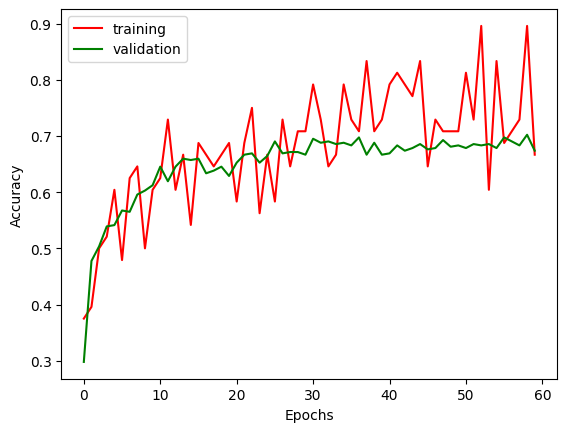

In [16]:
make_figure(training_acc_CNN, validation_acc_CNN, name = "CNN1")

In [17]:
###################################################################################
## No (2) Training and Test The CNN ###############################################
###################################################################################
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data_cnn = {
    "x_train": x_train_CNN,
    "y_train": y_train_CNN,
    "x_valid": x_valid_sub_1,
    "y_valid": y_valid_sub_1
}
training_acc_CNN, validation_acc_CNN = train_model(data_cnn, optimizer, criterion, cnn, batch_size, num_epoch)
start_time = time.time()
test_model(cnn, model_choice="CNN", X_test=X_test_subject_1, y_test=y_test_subject_1)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CNN(
  (model_nn): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.395
[1, 52] loss: 1.376
[1, 78] loss: 1.345


  2%|▏         | 1/60 [00:01<01:35,  1.63s/it]

[1, 104] loss: 1.333
Validation Accuracy: 0.1702127605676651
Epoch:  2
[2, 26] loss: 1.289
[2, 52] loss: 1.261
[2, 78] loss: 1.239


  3%|▎         | 2/60 [00:03<01:31,  1.58s/it]

[2, 104] loss: 1.248
Validation Accuracy: 0.4893616735935211
Epoch:  3
[3, 26] loss: 1.196
[3, 52] loss: 1.177
[3, 78] loss: 1.157


  5%|▌         | 3/60 [00:04<01:29,  1.57s/it]

[3, 104] loss: 1.150
Validation Accuracy: 0.42553189396858215
Epoch:  4
[4, 26] loss: 1.129
[4, 52] loss: 1.138
[4, 78] loss: 1.126


  7%|▋         | 4/60 [00:06<01:27,  1.56s/it]

[4, 104] loss: 1.088
Validation Accuracy: 0.5106382966041565
Epoch:  5
[5, 26] loss: 1.075
[5, 52] loss: 1.120
[5, 78] loss: 1.078


  8%|▊         | 5/60 [00:07<01:25,  1.56s/it]

[5, 104] loss: 1.083
Validation Accuracy: 0.5319148898124695
Epoch:  6
[6, 26] loss: 1.042
[6, 52] loss: 1.039
[6, 78] loss: 1.050


 10%|█         | 6/60 [00:09<01:24,  1.56s/it]

[6, 104] loss: 1.049
Validation Accuracy: 0.5319148898124695
Epoch:  7
[7, 26] loss: 1.005
[7, 52] loss: 1.021
[7, 78] loss: 1.026


 12%|█▏        | 7/60 [00:10<01:22,  1.56s/it]

[7, 104] loss: 0.984
Validation Accuracy: 0.5531914830207825
Epoch:  8
[8, 26] loss: 0.984
[8, 52] loss: 0.983
[8, 78] loss: 0.977


 13%|█▎        | 8/60 [00:12<01:21,  1.56s/it]

[8, 104] loss: 0.955
Validation Accuracy: 0.5531914830207825
Epoch:  9
[9, 26] loss: 0.950
[9, 52] loss: 0.940
[9, 78] loss: 0.932


 15%|█▌        | 9/60 [00:14<01:19,  1.56s/it]

[9, 104] loss: 0.918
Validation Accuracy: 0.5106382966041565
Epoch:  10
[10, 26] loss: 0.930
[10, 52] loss: 0.928
[10, 78] loss: 0.879


 17%|█▋        | 10/60 [00:15<01:18,  1.56s/it]

[10, 104] loss: 0.948
Validation Accuracy: 0.5531914830207825
Epoch:  11
[11, 26] loss: 0.913
[11, 52] loss: 0.876
[11, 78] loss: 0.926


 18%|█▊        | 11/60 [00:17<01:16,  1.56s/it]

[11, 104] loss: 0.873
Validation Accuracy: 0.5744680762290955
Epoch:  12
[12, 26] loss: 0.870
[12, 52] loss: 0.900
[12, 78] loss: 0.875


 20%|██        | 12/60 [00:18<01:15,  1.56s/it]

[12, 104] loss: 0.878
Validation Accuracy: 0.6170212626457214
Epoch:  13
[13, 26] loss: 0.844
[13, 52] loss: 0.861
[13, 78] loss: 0.828


 22%|██▏       | 13/60 [00:20<01:13,  1.56s/it]

[13, 104] loss: 0.864
Validation Accuracy: 0.6595744490623474
Epoch:  14
[14, 26] loss: 0.843
[14, 52] loss: 0.823
[14, 78] loss: 0.867


 23%|██▎       | 14/60 [00:21<01:12,  1.57s/it]

[14, 104] loss: 0.887
Validation Accuracy: 0.7021276354789734
Epoch:  15
[15, 26] loss: 0.835
[15, 52] loss: 0.844
[15, 78] loss: 0.820


 25%|██▌       | 15/60 [00:23<01:10,  1.57s/it]

[15, 104] loss: 0.799
Validation Accuracy: 0.7021276354789734
Epoch:  16
[16, 26] loss: 0.804
[16, 52] loss: 0.835
[16, 78] loss: 0.856


 27%|██▋       | 16/60 [00:25<01:09,  1.57s/it]

[16, 104] loss: 0.831
Validation Accuracy: 0.6595744490623474
Epoch:  17
[17, 26] loss: 0.760
[17, 52] loss: 0.778
[17, 78] loss: 0.792


 28%|██▊       | 17/60 [00:26<01:07,  1.58s/it]

[17, 104] loss: 0.801
Validation Accuracy: 0.7446808218955994
Epoch:  18
[18, 26] loss: 0.802
[18, 52] loss: 0.777
[18, 78] loss: 0.821


 30%|███       | 18/60 [00:28<01:06,  1.58s/it]

[18, 104] loss: 0.819
Validation Accuracy: 0.7021276354789734
Epoch:  19
[19, 26] loss: 0.782
[19, 52] loss: 0.766
[19, 78] loss: 0.778


 32%|███▏      | 19/60 [00:29<01:04,  1.58s/it]

[19, 104] loss: 0.728
Validation Accuracy: 0.7872340083122253
Epoch:  20
[20, 26] loss: 0.781
[20, 52] loss: 0.772
[20, 78] loss: 0.746


 33%|███▎      | 20/60 [00:31<01:03,  1.58s/it]

[20, 104] loss: 0.747
Validation Accuracy: 0.6808510422706604
Epoch:  21
[21, 26] loss: 0.757
[21, 52] loss: 0.731
[21, 78] loss: 0.775


 35%|███▌      | 21/60 [00:32<01:01,  1.58s/it]

[21, 104] loss: 0.723
Validation Accuracy: 0.6808510422706604
Epoch:  22
[22, 26] loss: 0.739
[22, 52] loss: 0.733
[22, 78] loss: 0.719


 37%|███▋      | 22/60 [00:34<00:59,  1.58s/it]

[22, 104] loss: 0.747
Validation Accuracy: 0.7021276354789734
Epoch:  23
[23, 26] loss: 0.760
[23, 52] loss: 0.742
[23, 78] loss: 0.785


 38%|███▊      | 23/60 [00:36<00:58,  1.58s/it]

[23, 104] loss: 0.741
Validation Accuracy: 0.5957446694374084
Epoch:  24
[24, 26] loss: 0.716
[24, 52] loss: 0.750
[24, 78] loss: 0.719


 40%|████      | 24/60 [00:37<00:56,  1.58s/it]

[24, 104] loss: 0.722
Validation Accuracy: 0.7234042286872864
Epoch:  25
[25, 26] loss: 0.728
[25, 52] loss: 0.726
[25, 78] loss: 0.727


 42%|████▏     | 25/60 [00:39<00:55,  1.59s/it]

[25, 104] loss: 0.704
Validation Accuracy: 0.6595744490623474
Epoch:  26
[26, 26] loss: 0.697
[26, 52] loss: 0.716
[26, 78] loss: 0.736


 43%|████▎     | 26/60 [00:40<00:53,  1.59s/it]

[26, 104] loss: 0.714
Validation Accuracy: 0.7659574151039124
Epoch:  27
[27, 26] loss: 0.692
[27, 52] loss: 0.714
[27, 78] loss: 0.694


 45%|████▌     | 27/60 [00:42<00:52,  1.59s/it]

[27, 104] loss: 0.727
Validation Accuracy: 0.7234042286872864
Epoch:  28
[28, 26] loss: 0.715
[28, 52] loss: 0.708
[28, 78] loss: 0.699


 47%|████▋     | 28/60 [00:44<00:50,  1.59s/it]

[28, 104] loss: 0.711
Validation Accuracy: 0.7446808218955994
Epoch:  29
[29, 26] loss: 0.700
[29, 52] loss: 0.698
[29, 78] loss: 0.715


 48%|████▊     | 29/60 [00:45<00:49,  1.58s/it]

[29, 104] loss: 0.711
Validation Accuracy: 0.7872340083122253
Epoch:  30
[30, 26] loss: 0.674
[30, 52] loss: 0.735
[30, 78] loss: 0.694


 50%|█████     | 30/60 [00:47<00:47,  1.58s/it]

[30, 104] loss: 0.676
Validation Accuracy: 0.7659574151039124
Epoch:  31
[31, 26] loss: 0.680
[31, 52] loss: 0.685
[31, 78] loss: 0.700


 52%|█████▏    | 31/60 [00:48<00:45,  1.58s/it]

[31, 104] loss: 0.709
Validation Accuracy: 0.7234042286872864
Epoch:  32
[32, 26] loss: 0.701
[32, 52] loss: 0.694
[32, 78] loss: 0.641


 53%|█████▎    | 32/60 [00:50<00:44,  1.58s/it]

[32, 104] loss: 0.681
Validation Accuracy: 0.7234042286872864
Epoch:  33
[33, 26] loss: 0.678
[33, 52] loss: 0.709
[33, 78] loss: 0.683


 55%|█████▌    | 33/60 [00:51<00:42,  1.58s/it]

[33, 104] loss: 0.687
Validation Accuracy: 0.7234042286872864
Epoch:  34
[34, 26] loss: 0.665
[34, 52] loss: 0.673
[34, 78] loss: 0.676


 57%|█████▋    | 34/60 [00:53<00:41,  1.58s/it]

[34, 104] loss: 0.701
Validation Accuracy: 0.8085106015205383
Epoch:  35
[35, 26] loss: 0.683
[35, 52] loss: 0.661
[35, 78] loss: 0.675


 58%|█████▊    | 35/60 [00:55<00:39,  1.58s/it]

[35, 104] loss: 0.666
Validation Accuracy: 0.7872340083122253
Epoch:  36
[36, 26] loss: 0.671
[36, 52] loss: 0.648
[36, 78] loss: 0.643


 60%|██████    | 36/60 [00:56<00:37,  1.58s/it]

[36, 104] loss: 0.690
Validation Accuracy: 0.7872340083122253
Epoch:  37
[37, 26] loss: 0.703
[37, 52] loss: 0.676
[37, 78] loss: 0.656


 62%|██████▏   | 37/60 [00:58<00:36,  1.58s/it]

[37, 104] loss: 0.659
Validation Accuracy: 0.8297871947288513
Epoch:  38
[38, 26] loss: 0.668
[38, 52] loss: 0.660
[38, 78] loss: 0.659


 63%|██████▎   | 38/60 [00:59<00:34,  1.57s/it]

[38, 104] loss: 0.675
Validation Accuracy: 0.7872340083122253
Epoch:  39
[39, 26] loss: 0.603
[39, 52] loss: 0.655
[39, 78] loss: 0.631


 65%|██████▌   | 39/60 [01:01<00:33,  1.57s/it]

[39, 104] loss: 0.663
Validation Accuracy: 0.8510637879371643
Epoch:  40
[40, 26] loss: 0.652
[40, 52] loss: 0.662
[40, 78] loss: 0.629


 67%|██████▋   | 40/60 [01:02<00:31,  1.58s/it]

[40, 104] loss: 0.651
Validation Accuracy: 0.8723403811454773
Epoch:  41
[41, 26] loss: 0.646
[41, 52] loss: 0.644
[41, 78] loss: 0.630


 68%|██████▊   | 41/60 [01:04<00:29,  1.58s/it]

[41, 104] loss: 0.628
Validation Accuracy: 0.8510637879371643
Epoch:  42
[42, 26] loss: 0.663
[42, 52] loss: 0.627
[42, 78] loss: 0.652


 70%|███████   | 42/60 [01:06<00:28,  1.58s/it]

[42, 104] loss: 0.655
Validation Accuracy: 0.8297871947288513
Epoch:  43
[43, 26] loss: 0.622
[43, 52] loss: 0.674
[43, 78] loss: 0.645


 72%|███████▏  | 43/60 [01:07<00:26,  1.57s/it]

[43, 104] loss: 0.646
Validation Accuracy: 0.8085106015205383
Epoch:  44
[44, 26] loss: 0.611
[44, 52] loss: 0.600
[44, 78] loss: 0.641


 73%|███████▎  | 44/60 [01:09<00:25,  1.57s/it]

[44, 104] loss: 0.621
Validation Accuracy: 0.8936169743537903
Epoch:  45
[45, 26] loss: 0.589
[45, 52] loss: 0.634
[45, 78] loss: 0.646


 75%|███████▌  | 45/60 [01:10<00:23,  1.57s/it]

[45, 104] loss: 0.659
Validation Accuracy: 0.8723403811454773
Epoch:  46
[46, 26] loss: 0.606
[46, 52] loss: 0.632
[46, 78] loss: 0.651


 77%|███████▋  | 46/60 [01:12<00:22,  1.57s/it]

[46, 104] loss: 0.658
Validation Accuracy: 0.7872340083122253
Epoch:  47
[47, 26] loss: 0.663
[47, 52] loss: 0.627
[47, 78] loss: 0.643


 78%|███████▊  | 47/60 [01:13<00:20,  1.57s/it]

[47, 104] loss: 0.631
Validation Accuracy: 0.8510637879371643
Epoch:  48
[48, 26] loss: 0.637
[48, 52] loss: 0.575
[48, 78] loss: 0.607


 80%|████████  | 48/60 [01:15<00:18,  1.57s/it]

[48, 104] loss: 0.649
Validation Accuracy: 0.7872340083122253
Epoch:  49
[49, 26] loss: 0.612
[49, 52] loss: 0.639
[49, 78] loss: 0.657


 82%|████████▏ | 49/60 [01:17<00:17,  1.57s/it]

[49, 104] loss: 0.656
Validation Accuracy: 0.8297871947288513
Epoch:  50
[50, 26] loss: 0.598
[50, 52] loss: 0.621
[50, 78] loss: 0.645


 83%|████████▎ | 50/60 [01:18<00:15,  1.57s/it]

[50, 104] loss: 0.613
Validation Accuracy: 0.8723403811454773
Epoch:  51
[51, 26] loss: 0.616
[51, 52] loss: 0.599
[51, 78] loss: 0.644


 85%|████████▌ | 51/60 [01:20<00:14,  1.57s/it]

[51, 104] loss: 0.678
Validation Accuracy: 0.8936169743537903
Epoch:  52
[52, 26] loss: 0.563
[52, 52] loss: 0.649
[52, 78] loss: 0.584


 87%|████████▋ | 52/60 [01:21<00:12,  1.57s/it]

[52, 104] loss: 0.641
Validation Accuracy: 0.8510637879371643
Epoch:  53
[53, 26] loss: 0.601
[53, 52] loss: 0.679
[53, 78] loss: 0.614


 88%|████████▊ | 53/60 [01:23<00:10,  1.57s/it]

[53, 104] loss: 0.632
Validation Accuracy: 0.8510637879371643
Epoch:  54
[54, 26] loss: 0.565
[54, 52] loss: 0.621
[54, 78] loss: 0.605


 90%|█████████ | 54/60 [01:24<00:09,  1.57s/it]

[54, 104] loss: 0.607
Validation Accuracy: 0.8723403811454773
Epoch:  55
[55, 26] loss: 0.610
[55, 52] loss: 0.594
[55, 78] loss: 0.606


 92%|█████████▏| 55/60 [01:26<00:07,  1.57s/it]

[55, 104] loss: 0.617
Validation Accuracy: 0.8085106015205383
Epoch:  56
[56, 26] loss: 0.563
[56, 52] loss: 0.642
[56, 78] loss: 0.639


 93%|█████████▎| 56/60 [01:28<00:06,  1.58s/it]

[56, 104] loss: 0.626
Validation Accuracy: 0.9148935675621033
Epoch:  57
[57, 26] loss: 0.585
[57, 52] loss: 0.600
[57, 78] loss: 0.618


 95%|█████████▌| 57/60 [01:29<00:04,  1.58s/it]

[57, 104] loss: 0.586
Validation Accuracy: 0.9148935675621033
Epoch:  58
[58, 26] loss: 0.593
[58, 52] loss: 0.607
[58, 78] loss: 0.586


 97%|█████████▋| 58/60 [01:31<00:03,  1.58s/it]

[58, 104] loss: 0.584
Validation Accuracy: 0.7872340083122253
Epoch:  59
[59, 26] loss: 0.575
[59, 52] loss: 0.577
[59, 78] loss: 0.597


 98%|█████████▊| 59/60 [01:32<00:01,  1.57s/it]

[59, 104] loss: 0.648
Validation Accuracy: 0.8085106015205383
Epoch:  60
[60, 26] loss: 0.579
[60, 52] loss: 0.557
[60, 78] loss: 0.580


100%|██████████| 60/60 [01:34<00:00,  1.57s/it]

[60, 104] loss: 0.603
Validation Accuracy: 0.8936169743537903
Finish Training
Test accuracy for  CNN is:  0.5
Time To Run:  0.029480457305908203 seconds


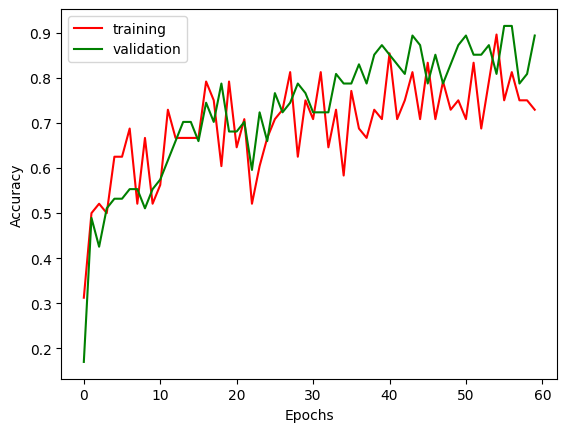

In [18]:
make_figure(training_acc_CNN, validation_acc_CNN, name = "CNN2")

In [19]:
###################################################################################
## No (3) Training and Test The CNN ###############################################
###################################################################################
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 60, 64
data_cnn = {
    "x_train": x_train_sub_1,
    "y_train": y_train_sub_1,
    "x_valid": x_valid_sub_1,
    "y_valid": y_valid_sub_1
}
training_acc_CNN, validation_acc_CNN = train_model(data_cnn, optimizer, criterion, cnn, batch_size, num_epoch)
start_time = time.time()
test_model(cnn, model_choice="CNN", X_test=X_test_subject_1, y_test=y_test_subject_1)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CNN(
  (model_nn): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p

  2%|▏         | 1/60 [00:00<00:10,  5.57it/s]

Epoch:  1
[1, 3] loss: 1.432
[1, 6] loss: 1.427
[1, 9] loss: 1.422
[1, 12] loss: 1.402
Validation Accuracy: 0.1914893537759781
Epoch:  2


  3%|▎         | 2/60 [00:00<00:10,  5.59it/s]

[2, 3] loss: 1.434
[2, 6] loss: 1.375
[2, 9] loss: 1.321
[2, 12] loss: 1.347
Validation Accuracy: 0.25531914830207825
Epoch:  3
[3, 3] loss: 1.378


  5%|▌         | 3/60 [00:00<00:10,  5.54it/s]

[3, 6] loss: 1.330
[3, 9] loss: 1.305
[3, 12] loss: 1.346
Validation Accuracy: 0.25531914830207825
Epoch:  4
[4, 3] loss: 1.339
[4, 6] loss: 1.325


  7%|▋         | 4/60 [00:00<00:10,  5.54it/s]

[4, 9] loss: 1.275
[4, 12] loss: 1.323
Validation Accuracy: 0.2978723347187042
Epoch:  5
[5, 3] loss: 1.304
[5, 6] loss: 1.268
[5, 9] loss: 1.248


 10%|█         | 6/60 [00:01<00:10,  5.40it/s]

[5, 12] loss: 1.295
Validation Accuracy: 0.25531914830207825
Epoch:  6
[6, 3] loss: 1.231
[6, 6] loss: 1.249
[6, 9] loss: 1.263
[6, 12] loss: 1.224
Validation Accuracy: 0.27659574151039124
Epoch:  7


 12%|█▏        | 7/60 [00:01<00:09,  5.43it/s]

[7, 3] loss: 1.258
[7, 6] loss: 1.247
[7, 9] loss: 1.207
[7, 12] loss: 1.146
Validation Accuracy: 0.23404254019260406
Epoch:  8
[8, 3] loss: 1.234


 13%|█▎        | 8/60 [00:01<00:09,  5.46it/s]

[8, 6] loss: 1.196
[8, 9] loss: 1.129
[8, 12] loss: 1.127
Validation Accuracy: 0.25531914830207825
Epoch:  9
[9, 3] loss: 1.075
[9, 6] loss: 1.184


 15%|█▌        | 9/60 [00:01<00:09,  5.45it/s]

[9, 9] loss: 1.164
[9, 12] loss: 1.139
Validation Accuracy: 0.25531914830207825
Epoch:  10
[10, 3] loss: 1.108
[10, 6] loss: 1.111
[10, 9] loss: 1.084


 18%|█▊        | 11/60 [00:02<00:09,  5.40it/s]

[10, 12] loss: 1.077
Validation Accuracy: 0.27659574151039124
Epoch:  11
[11, 3] loss: 1.039
[11, 6] loss: 0.982
[11, 9] loss: 1.081
[11, 12] loss: 1.044
Validation Accuracy: 0.3617021143436432
Epoch:  12


 20%|██        | 12/60 [00:02<00:08,  5.44it/s]

[12, 3] loss: 1.052
[12, 6] loss: 1.049
[12, 9] loss: 1.023
[12, 12] loss: 0.965
Validation Accuracy: 0.23404254019260406
Epoch:  13
[13, 3] loss: 0.939


 22%|██▏       | 13/60 [00:02<00:08,  5.44it/s]

[13, 6] loss: 0.970
[13, 9] loss: 0.957
[13, 12] loss: 0.963
Validation Accuracy: 0.27659574151039124
Epoch:  14
[14, 3] loss: 0.969
[14, 6] loss: 0.947


 23%|██▎       | 14/60 [00:02<00:08,  5.46it/s]

[14, 9] loss: 0.927
[14, 12] loss: 1.000
Validation Accuracy: 0.3404255211353302
Epoch:  15
[15, 3] loss: 0.893
[15, 6] loss: 0.933
[15, 9] loss: 0.886


 27%|██▋       | 16/60 [00:02<00:08,  5.43it/s]

[15, 12] loss: 0.900
Validation Accuracy: 0.3191489279270172
Epoch:  16
[16, 3] loss: 0.806
[16, 6] loss: 0.920
[16, 9] loss: 0.768
[16, 12] loss: 0.902
Validation Accuracy: 0.2978723347187042
Epoch:  17


 28%|██▊       | 17/60 [00:03<00:07,  5.40it/s]

[17, 3] loss: 0.816
[17, 6] loss: 0.686
[17, 9] loss: 0.815
[17, 12] loss: 0.818
Validation Accuracy: 0.2978723347187042
Epoch:  18
[18, 3] loss: 0.759


 30%|███       | 18/60 [00:03<00:07,  5.43it/s]

[18, 6] loss: 0.710
[18, 9] loss: 0.798
[18, 12] loss: 0.841
Validation Accuracy: 0.3191489279270172
Epoch:  19
[19, 3] loss: 0.789
[19, 6] loss: 0.796


 32%|███▏      | 19/60 [00:03<00:07,  5.46it/s]

[19, 9] loss: 0.769
[19, 12] loss: 0.649
Validation Accuracy: 0.3191489279270172
Epoch:  20
[20, 3] loss: 0.725
[20, 6] loss: 0.712
[20, 9] loss: 0.764


 35%|███▌      | 21/60 [00:03<00:07,  5.44it/s]

[20, 12] loss: 0.642
Validation Accuracy: 0.3404255211353302
Epoch:  21
[21, 3] loss: 0.663
[21, 6] loss: 0.634
[21, 9] loss: 0.556
[21, 12] loss: 0.674
Validation Accuracy: 0.3191489279270172
Epoch:  22


 37%|███▋      | 22/60 [00:04<00:07,  5.41it/s]

[22, 3] loss: 0.593
[22, 6] loss: 0.714
[22, 9] loss: 0.582
[22, 12] loss: 0.725
Validation Accuracy: 0.3617021143436432
Epoch:  23
[23, 3] loss: 0.539


 38%|███▊      | 23/60 [00:04<00:06,  5.42it/s]

[23, 6] loss: 0.628
[23, 9] loss: 0.641
[23, 12] loss: 0.527
Validation Accuracy: 0.3617021143436432
Epoch:  24
[24, 3] loss: 0.579
[24, 6] loss: 0.560


 40%|████      | 24/60 [00:04<00:06,  5.41it/s]

[24, 9] loss: 0.561
[24, 12] loss: 0.548
Validation Accuracy: 0.40425530076026917
Epoch:  25
[25, 3] loss: 0.514
[25, 6] loss: 0.541
[25, 9] loss: 0.520


 43%|████▎     | 26/60 [00:04<00:06,  5.43it/s]

[25, 12] loss: 0.584
Validation Accuracy: 0.3829787075519562
Epoch:  26
[26, 3] loss: 0.550
[26, 6] loss: 0.452
[26, 9] loss: 0.493
[26, 12] loss: 0.382
Validation Accuracy: 0.3829787075519562
Epoch:  27


 45%|████▌     | 27/60 [00:04<00:06,  5.41it/s]

[27, 3] loss: 0.463
[27, 6] loss: 0.595
[27, 9] loss: 0.400
[27, 12] loss: 0.449
Validation Accuracy: 0.40425530076026917
Epoch:  28
[28, 3] loss: 0.528


 47%|████▋     | 28/60 [00:05<00:05,  5.41it/s]

[28, 6] loss: 0.443
[28, 9] loss: 0.448
[28, 12] loss: 0.428
Validation Accuracy: 0.40425530076026917
Epoch:  29
[29, 3] loss: 0.463
[29, 6] loss: 0.503


 48%|████▊     | 29/60 [00:05<00:05,  5.39it/s]

[29, 9] loss: 0.402
[29, 12] loss: 0.433
Validation Accuracy: 0.42553189396858215
Epoch:  30
[30, 3] loss: 0.356
[30, 6] loss: 0.360
[30, 9] loss: 0.475


 52%|█████▏    | 31/60 [00:05<00:05,  5.43it/s]

[30, 12] loss: 0.437
Validation Accuracy: 0.40425530076026917
Epoch:  31
[31, 3] loss: 0.529
[31, 6] loss: 0.421
[31, 9] loss: 0.357
[31, 12] loss: 0.370
Validation Accuracy: 0.3829787075519562
Epoch:  32


 53%|█████▎    | 32/60 [00:05<00:05,  5.40it/s]

[32, 3] loss: 0.369
[32, 6] loss: 0.407
[32, 9] loss: 0.378
[32, 12] loss: 0.349
Validation Accuracy: 0.3617021143436432
Epoch:  33
[33, 3] loss: 0.411


 55%|█████▌    | 33/60 [00:06<00:05,  5.39it/s]

[33, 6] loss: 0.461
[33, 9] loss: 0.371
[33, 12] loss: 0.352
Validation Accuracy: 0.40425530076026917
Epoch:  34
[34, 3] loss: 0.362
[34, 6] loss: 0.352


 57%|█████▋    | 34/60 [00:06<00:04,  5.39it/s]

[34, 9] loss: 0.343
[34, 12] loss: 0.343
Validation Accuracy: 0.44680848717689514
Epoch:  35
[35, 3] loss: 0.276
[35, 6] loss: 0.398
[35, 9] loss: 0.319


 60%|██████    | 36/60 [00:06<00:04,  5.36it/s]

[35, 12] loss: 0.381
Validation Accuracy: 0.42553189396858215
Epoch:  36
[36, 3] loss: 0.410
[36, 6] loss: 0.341
[36, 9] loss: 0.380
[36, 12] loss: 0.419
Validation Accuracy: 0.42553189396858215
Epoch:  37


 62%|██████▏   | 37/60 [00:06<00:04,  5.33it/s]

[37, 3] loss: 0.331
[37, 6] loss: 0.404
[37, 9] loss: 0.309
[37, 12] loss: 0.334
Validation Accuracy: 0.42553189396858215
Epoch:  38
[38, 3] loss: 0.359


 63%|██████▎   | 38/60 [00:07<00:04,  5.32it/s]

[38, 6] loss: 0.304
[38, 9] loss: 0.331
[38, 12] loss: 0.310
Validation Accuracy: 0.42553189396858215
Epoch:  39
[39, 3] loss: 0.251
[39, 6] loss: 0.352


 65%|██████▌   | 39/60 [00:07<00:03,  5.33it/s]

[39, 9] loss: 0.264
[39, 12] loss: 0.266
Validation Accuracy: 0.42553189396858215
Epoch:  40
[40, 3] loss: 0.319
[40, 6] loss: 0.298
[40, 9] loss: 0.328


 68%|██████▊   | 41/60 [00:07<00:03,  5.37it/s]

[40, 12] loss: 0.303
Validation Accuracy: 0.3404255211353302
Epoch:  41
[41, 3] loss: 0.339
[41, 6] loss: 0.302
[41, 9] loss: 0.250
[41, 12] loss: 0.299
Validation Accuracy: 0.3617021143436432
Epoch:  42


 70%|███████   | 42/60 [00:07<00:03,  5.38it/s]

[42, 3] loss: 0.275
[42, 6] loss: 0.310
[42, 9] loss: 0.353
[42, 12] loss: 0.269
Validation Accuracy: 0.3617021143436432
Epoch:  43
[43, 3] loss: 0.267


 72%|███████▏  | 43/60 [00:07<00:03,  5.37it/s]

[43, 6] loss: 0.246
[43, 9] loss: 0.283
[43, 12] loss: 0.313
Validation Accuracy: 0.40425530076026917
Epoch:  44
[44, 3] loss: 0.329
[44, 6] loss: 0.273


 73%|███████▎  | 44/60 [00:08<00:02,  5.34it/s]

[44, 9] loss: 0.246
[44, 12] loss: 0.266
Validation Accuracy: 0.3404255211353302
Epoch:  45
[45, 3] loss: 0.198
[45, 6] loss: 0.362
[45, 9] loss: 0.229


 77%|███████▋  | 46/60 [00:08<00:02,  5.38it/s]

[45, 12] loss: 0.249
Validation Accuracy: 0.3617021143436432
Epoch:  46
[46, 3] loss: 0.292
[46, 6] loss: 0.302
[46, 9] loss: 0.321
[46, 12] loss: 0.230
Validation Accuracy: 0.42553189396858215
Epoch:  47


 78%|███████▊  | 47/60 [00:08<00:02,  5.38it/s]

[47, 3] loss: 0.263
[47, 6] loss: 0.290
[47, 9] loss: 0.188
[47, 12] loss: 0.254
Validation Accuracy: 0.3617021143436432
Epoch:  48
[48, 3] loss: 0.286


 80%|████████  | 48/60 [00:08<00:02,  5.40it/s]

[48, 6] loss: 0.162
[48, 9] loss: 0.263
[48, 12] loss: 0.240
Validation Accuracy: 0.3191489279270172
Epoch:  49
[49, 3] loss: 0.194
[49, 6] loss: 0.196


 82%|████████▏ | 49/60 [00:09<00:02,  5.41it/s]

[49, 9] loss: 0.287
[49, 12] loss: 0.179
Validation Accuracy: 0.3404255211353302
Epoch:  50
[50, 3] loss: 0.196
[50, 6] loss: 0.251
[50, 9] loss: 0.294


 85%|████████▌ | 51/60 [00:09<00:01,  5.44it/s]

[50, 12] loss: 0.206
Validation Accuracy: 0.42553189396858215
Epoch:  51
[51, 3] loss: 0.216
[51, 6] loss: 0.227
[51, 9] loss: 0.276
[51, 12] loss: 0.231
Validation Accuracy: 0.3404255211353302
Epoch:  52


 87%|████████▋ | 52/60 [00:09<00:01,  5.45it/s]

[52, 3] loss: 0.201
[52, 6] loss: 0.210
[52, 9] loss: 0.184
[52, 12] loss: 0.304
Validation Accuracy: 0.3404255211353302
Epoch:  53
[53, 3] loss: 0.208


 88%|████████▊ | 53/60 [00:09<00:01,  5.44it/s]

[53, 6] loss: 0.196
[53, 9] loss: 0.262
[53, 12] loss: 0.179
Validation Accuracy: 0.3617021143436432
Epoch:  54
[54, 3] loss: 0.176
[54, 6] loss: 0.182


 90%|█████████ | 54/60 [00:09<00:01,  5.42it/s]

[54, 9] loss: 0.314
[54, 12] loss: 0.211
Validation Accuracy: 0.3617021143436432
Epoch:  55
[55, 3] loss: 0.184
[55, 6] loss: 0.255
[55, 9] loss: 0.287


 93%|█████████▎| 56/60 [00:10<00:00,  5.44it/s]

[55, 12] loss: 0.265
Validation Accuracy: 0.40425530076026917
Epoch:  56
[56, 3] loss: 0.143
[56, 6] loss: 0.203
[56, 9] loss: 0.195
[56, 12] loss: 0.220
Validation Accuracy: 0.3191489279270172
Epoch:  57


 95%|█████████▌| 57/60 [00:10<00:00,  5.43it/s]

[57, 3] loss: 0.156
[57, 6] loss: 0.270
[57, 9] loss: 0.198
[57, 12] loss: 0.182
Validation Accuracy: 0.3829787075519562
Epoch:  58
[58, 3] loss: 0.235


 97%|█████████▋| 58/60 [00:10<00:00,  5.43it/s]

[58, 6] loss: 0.174
[58, 9] loss: 0.204
[58, 12] loss: 0.234
Validation Accuracy: 0.40425530076026917
Epoch:  59
[59, 3] loss: 0.176
[59, 6] loss: 0.204


 98%|█████████▊| 59/60 [00:10<00:00,  5.43it/s]

[59, 9] loss: 0.195
[59, 12] loss: 0.181
Validation Accuracy: 0.40425530076026917
Epoch:  60
[60, 3] loss: 0.208
[60, 6] loss: 0.202
[60, 9] loss: 0.174


100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


[60, 12] loss: 0.205
Validation Accuracy: 0.40425530076026917
Finish Training
Test accuracy for  CNN is:  0.48
Time To Run:  0.027856111526489258 seconds


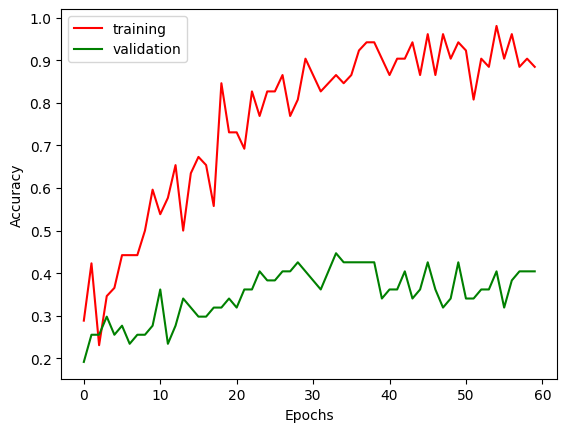

In [20]:
make_figure(training_acc_CNN, validation_acc_CNN, name = "CNN3")

In [21]:
###################################################################################
## No (1) Training and Test The EEGNet ############################################
###################################################################################
eegnet = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eegnet.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eegnet = {
    "x_train": x_train_EEG,
    "y_train": y_train_EEG,
    "x_valid": x_valid_EEG,
    "y_valid": y_valid_EEG
}
training_acc_EEGNet, validation_acc_EEGNet = train_model(data_eegnet, optimizer, criterion, eegnet, batch_size, num_epoch)
start_time = time.time()
test_model(eegnet, model_choice="EEGNet", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.360
[1, 52] loss: 1.290
[1, 78] loss: 1.246
[1, 104] loss: 1.198


  2%|▏         | 1/50 [00:01<00:49,  1.01s/it]

Validation Accuracy: 0.5106382966041565
Epoch:  2
[2, 26] loss: 1.129
[2, 52] loss: 1.100
[2, 78] loss: 1.036


  4%|▍         | 2/50 [00:01<00:42,  1.13it/s]

[2, 104] loss: 1.057
Validation Accuracy: 0.5555555820465088
Epoch:  3
[3, 26] loss: 1.009
[3, 52] loss: 1.001
[3, 78] loss: 1.016
[3, 104] loss: 1.000


  6%|▌         | 3/50 [00:02<00:40,  1.17it/s]

Validation Accuracy: 0.567375898361206
Epoch:  4
[4, 26] loss: 0.970
[4, 52] loss: 0.967
[4, 78] loss: 0.952


  8%|▊         | 4/50 [00:03<00:38,  1.20it/s]

[4, 104] loss: 0.933
Validation Accuracy: 0.5650117993354797
Epoch:  5
[5, 26] loss: 0.907
[5, 52] loss: 0.923
[5, 78] loss: 0.900
[5, 104] loss: 0.903


 10%|█         | 5/50 [00:04<00:37,  1.21it/s]

Validation Accuracy: 0.5815603137016296
Epoch:  6
[6, 26] loss: 0.880
[6, 52] loss: 0.849
[6, 78] loss: 0.862


 12%|█▏        | 6/50 [00:05<00:36,  1.22it/s]

[6, 104] loss: 0.876
Validation Accuracy: 0.6075649857521057
Epoch:  7
[7, 26] loss: 0.839
[7, 52] loss: 0.861
[7, 78] loss: 0.854
[7, 104] loss: 0.831


 14%|█▍        | 7/50 [00:05<00:35,  1.22it/s]

Validation Accuracy: 0.6146572232246399
Epoch:  8
[8, 26] loss: 0.819
[8, 52] loss: 0.851
[8, 78] loss: 0.844
[8, 104] loss: 0.793


 16%|█▌        | 8/50 [00:06<00:34,  1.22it/s]

Validation Accuracy: 0.6170212626457214
Epoch:  9
[9, 26] loss: 0.787
[9, 52] loss: 0.776
[9, 78] loss: 0.797


 18%|█▊        | 9/50 [00:07<00:33,  1.22it/s]

[9, 104] loss: 0.850
Validation Accuracy: 0.6264775395393372
Epoch:  10
[10, 26] loss: 0.757
[10, 52] loss: 0.808
[10, 78] loss: 0.764
[10, 104] loss: 0.793


 20%|██        | 10/50 [00:08<00:32,  1.22it/s]

Validation Accuracy: 0.6217494010925293
Epoch:  11
[11, 26] loss: 0.781
[11, 52] loss: 0.740
[11, 78] loss: 0.777


 22%|██▏       | 11/50 [00:09<00:32,  1.22it/s]

[11, 104] loss: 0.788
Validation Accuracy: 0.6217494010925293
Epoch:  12
[12, 26] loss: 0.758
[12, 52] loss: 0.728
[12, 78] loss: 0.713
[12, 104] loss: 0.748


 24%|██▍       | 12/50 [00:09<00:31,  1.22it/s]

Validation Accuracy: 0.6453900933265686
Epoch:  13
[13, 26] loss: 0.705
[13, 52] loss: 0.724
[13, 78] loss: 0.754


 26%|██▌       | 13/50 [00:10<00:30,  1.23it/s]

[13, 104] loss: 0.723
Validation Accuracy: 0.6453900933265686
Epoch:  14
[14, 26] loss: 0.713
[14, 52] loss: 0.710
[14, 78] loss: 0.702
[14, 104] loss: 0.748


 28%|██▊       | 14/50 [00:11<00:29,  1.23it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  15
[15, 26] loss: 0.694
[15, 52] loss: 0.699
[15, 78] loss: 0.684


 30%|███       | 15/50 [00:12<00:28,  1.23it/s]

[15, 104] loss: 0.705
Validation Accuracy: 0.6501182317733765
Epoch:  16
[16, 26] loss: 0.706
[16, 52] loss: 0.654
[16, 78] loss: 0.669
[16, 104] loss: 0.676


 32%|███▏      | 16/50 [00:13<00:27,  1.23it/s]

Validation Accuracy: 0.6832151412963867
Epoch:  17
[17, 26] loss: 0.673
[17, 52] loss: 0.671
[17, 78] loss: 0.670


 34%|███▍      | 17/50 [00:14<00:26,  1.23it/s]

[17, 104] loss: 0.663
Validation Accuracy: 0.6595744490623474
Epoch:  18
[18, 26] loss: 0.688
[18, 52] loss: 0.636
[18, 78] loss: 0.639
[18, 104] loss: 0.691


 36%|███▌      | 18/50 [00:14<00:26,  1.23it/s]

Validation Accuracy: 0.6619385480880737
Epoch:  19
[19, 26] loss: 0.639
[19, 52] loss: 0.644
[19, 78] loss: 0.624


 38%|███▊      | 19/50 [00:15<00:25,  1.23it/s]

[19, 104] loss: 0.665
Validation Accuracy: 0.6832151412963867
Epoch:  20
[20, 26] loss: 0.622
[20, 52] loss: 0.639
[20, 78] loss: 0.645
[20, 104] loss: 0.628


 40%|████      | 20/50 [00:16<00:24,  1.23it/s]

Validation Accuracy: 0.6832151412963867
Epoch:  21
[21, 26] loss: 0.607
[21, 52] loss: 0.624
[21, 78] loss: 0.655


 42%|████▏     | 21/50 [00:17<00:23,  1.23it/s]

[21, 104] loss: 0.637
Validation Accuracy: 0.6855791807174683
Epoch:  22
[22, 26] loss: 0.652
[22, 52] loss: 0.608
[22, 78] loss: 0.625
[22, 104] loss: 0.636


 44%|████▍     | 22/50 [00:18<00:22,  1.23it/s]

Validation Accuracy: 0.7044917345046997
Epoch:  23
[23, 26] loss: 0.619
[23, 52] loss: 0.608
[23, 78] loss: 0.624


 46%|████▌     | 23/50 [00:18<00:21,  1.23it/s]

[23, 104] loss: 0.603
Validation Accuracy: 0.6997635960578918
Epoch:  24
[24, 26] loss: 0.629
[24, 52] loss: 0.617
[24, 78] loss: 0.618
[24, 104] loss: 0.568


 48%|████▊     | 24/50 [00:19<00:21,  1.22it/s]

Validation Accuracy: 0.695035457611084
Epoch:  25
[25, 26] loss: 0.603
[25, 52] loss: 0.594
[25, 78] loss: 0.644
[25, 104] loss: 0.608


 50%|█████     | 25/50 [00:20<00:20,  1.22it/s]

Validation Accuracy: 0.7092198729515076
Epoch:  26
[26, 26] loss: 0.555
[26, 52] loss: 0.614
[26, 78] loss: 0.583
[26, 104] loss: 0.579


 52%|█████▏    | 26/50 [00:21<00:19,  1.22it/s]

Validation Accuracy: 0.6855791807174683
Epoch:  27
[27, 26] loss: 0.582
[27, 52] loss: 0.588
[27, 78] loss: 0.594


 54%|█████▍    | 27/50 [00:22<00:18,  1.22it/s]

[27, 104] loss: 0.591
Validation Accuracy: 0.7115839123725891
Epoch:  28
[28, 26] loss: 0.560
[28, 52] loss: 0.608
[28, 78] loss: 0.604
[28, 104] loss: 0.587


 56%|█████▌    | 28/50 [00:22<00:17,  1.23it/s]

Validation Accuracy: 0.6926714181900024
Epoch:  29
[29, 26] loss: 0.596
[29, 52] loss: 0.568
[29, 78] loss: 0.566


 58%|█████▊    | 29/50 [00:23<00:17,  1.23it/s]

[29, 104] loss: 0.575
Validation Accuracy: 0.7210401892662048
Epoch:  30
[30, 26] loss: 0.578
[30, 52] loss: 0.587
[30, 78] loss: 0.592
[30, 104] loss: 0.562


 60%|██████    | 30/50 [00:24<00:16,  1.23it/s]

Validation Accuracy: 0.6997635960578918
Epoch:  31
[31, 26] loss: 0.558
[31, 52] loss: 0.592
[31, 78] loss: 0.546


 62%|██████▏   | 31/50 [00:25<00:15,  1.23it/s]

[31, 104] loss: 0.554
Validation Accuracy: 0.7068557739257812
Epoch:  32
[32, 26] loss: 0.569
[32, 52] loss: 0.575
[32, 78] loss: 0.567
[32, 104] loss: 0.555


 64%|██████▍   | 32/50 [00:26<00:14,  1.23it/s]

Validation Accuracy: 0.7304964661598206
Epoch:  33
[33, 26] loss: 0.565
[33, 52] loss: 0.573
[33, 78] loss: 0.534


 66%|██████▌   | 33/50 [00:27<00:13,  1.23it/s]

[33, 104] loss: 0.573
Validation Accuracy: 0.7092198729515076
Epoch:  34
[34, 26] loss: 0.555
[34, 52] loss: 0.550
[34, 78] loss: 0.549
[34, 104] loss: 0.561


 68%|██████▊   | 34/50 [00:27<00:13,  1.23it/s]

Validation Accuracy: 0.7186761498451233
Epoch:  35
[35, 26] loss: 0.538
[35, 52] loss: 0.539
[35, 78] loss: 0.563


 70%|███████   | 35/50 [00:28<00:12,  1.23it/s]

[35, 104] loss: 0.558
Validation Accuracy: 0.716312050819397
Epoch:  36
[36, 26] loss: 0.513
[36, 52] loss: 0.532
[36, 78] loss: 0.545
[36, 104] loss: 0.539


 72%|███████▏  | 36/50 [00:29<00:11,  1.23it/s]

Validation Accuracy: 0.7234042286872864
Epoch:  37
[37, 26] loss: 0.524
[37, 52] loss: 0.520
[37, 78] loss: 0.551


 74%|███████▍  | 37/50 [00:30<00:10,  1.23it/s]

[37, 104] loss: 0.560
Validation Accuracy: 0.7186761498451233
Epoch:  38
[38, 26] loss: 0.530
[38, 52] loss: 0.525
[38, 78] loss: 0.553
[38, 104] loss: 0.494


 76%|███████▌  | 38/50 [00:31<00:09,  1.23it/s]

Validation Accuracy: 0.7352246046066284
Epoch:  39
[39, 26] loss: 0.527
[39, 52] loss: 0.564
[39, 78] loss: 0.521


 78%|███████▊  | 39/50 [00:31<00:08,  1.23it/s]

[39, 104] loss: 0.520
Validation Accuracy: 0.7139480113983154
Epoch:  40
[40, 26] loss: 0.513
[40, 52] loss: 0.510
[40, 78] loss: 0.510
[40, 104] loss: 0.534


 80%|████████  | 40/50 [00:32<00:08,  1.23it/s]

Validation Accuracy: 0.7352246046066284
Epoch:  41
[41, 26] loss: 0.499
[41, 52] loss: 0.523
[41, 78] loss: 0.550


 82%|████████▏ | 41/50 [00:33<00:07,  1.22it/s]

[41, 104] loss: 0.558
Validation Accuracy: 0.73758864402771
Epoch:  42
[42, 26] loss: 0.507
[42, 52] loss: 0.512
[42, 78] loss: 0.521
[42, 104] loss: 0.498


 84%|████████▍ | 42/50 [00:34<00:06,  1.22it/s]

Validation Accuracy: 0.7399527430534363
Epoch:  43
[43, 26] loss: 0.518
[43, 52] loss: 0.520
[43, 78] loss: 0.518


 86%|████████▌ | 43/50 [00:35<00:05,  1.23it/s]

[43, 104] loss: 0.465
Validation Accuracy: 0.7186761498451233
Epoch:  44
[44, 26] loss: 0.504
[44, 52] loss: 0.526
[44, 78] loss: 0.533
[44, 104] loss: 0.524


 88%|████████▊ | 44/50 [00:35<00:04,  1.23it/s]

Validation Accuracy: 0.7328605055809021
Epoch:  45
[45, 26] loss: 0.513
[45, 52] loss: 0.505
[45, 78] loss: 0.472


 90%|█████████ | 45/50 [00:36<00:04,  1.23it/s]

[45, 104] loss: 0.528
Validation Accuracy: 0.7186761498451233
Epoch:  46
[46, 26] loss: 0.482
[46, 52] loss: 0.488
[46, 78] loss: 0.493
[46, 104] loss: 0.497


 92%|█████████▏| 46/50 [00:37<00:03,  1.24it/s]

Validation Accuracy: 0.7139480113983154
Epoch:  47
[47, 26] loss: 0.497
[47, 52] loss: 0.491
[47, 78] loss: 0.496


 94%|█████████▍| 47/50 [00:38<00:02,  1.24it/s]

[47, 104] loss: 0.486
Validation Accuracy: 0.7092198729515076
Epoch:  48
[48, 26] loss: 0.511
[48, 52] loss: 0.519
[48, 78] loss: 0.447
[48, 104] loss: 0.480


 96%|█████████▌| 48/50 [00:39<00:01,  1.24it/s]

Validation Accuracy: 0.7234042286872864
Epoch:  49
[49, 26] loss: 0.509
[49, 52] loss: 0.504
[49, 78] loss: 0.516


 98%|█████████▊| 49/50 [00:40<00:00,  1.24it/s]

[49, 104] loss: 0.487
Validation Accuracy: 0.7257683277130127
Epoch:  50
[50, 26] loss: 0.504
[50, 52] loss: 0.499
[50, 78] loss: 0.465
[50, 104] loss: 0.515


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]

Validation Accuracy: 0.7139480113983154
Finish Training


Test accuracy for  EEGNet is:  0.7404063205417607
Time To Run:  0.20466113090515137 seconds


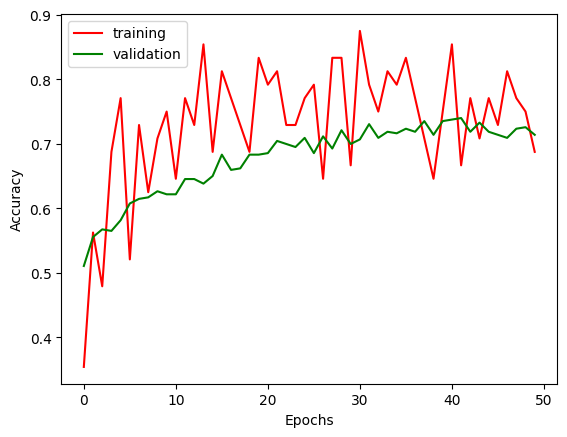

In [22]:
make_figure(training_acc_EEGNet, validation_acc_EEGNet, name = "EEGNet1")

In [23]:
###################################################################################
## No (2) Training and Test The EEGNet ############################################
###################################################################################
eegnet = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eegnet.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eegnet = {
    "x_train": x_train_EEG,
    "y_train": y_train_EEG,
    "x_valid": x_valid_sub_1_EEG,
    "y_valid": y_valid_sub_1_EEG
}
training_acc_EEGNet, validation_acc_EEGNet = train_model(data_eegnet, optimizer, criterion, eegnet, batch_size, num_epoch)
start_time = time.time()
test_model(eegnet, model_choice="EEGNet", X_test=X_test_subject_1, y_test=y_test_subject_1)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.345
[1, 52] loss: 1.269
[1, 78] loss: 1.186


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

[1, 104] loss: 1.110
Validation Accuracy: 0.4893616735935211
Epoch:  2
[2, 26] loss: 1.110
[2, 52] loss: 1.047
[2, 78] loss: 1.021
[2, 104] loss: 0.970


  4%|▍         | 2/50 [00:01<00:37,  1.26it/s]

Validation Accuracy: 0.5319148898124695
Epoch:  3
[3, 26] loss: 0.980
[3, 52] loss: 0.956
[3, 78] loss: 0.926


  6%|▌         | 3/50 [00:02<00:37,  1.25it/s]

[3, 104] loss: 0.927
Validation Accuracy: 0.5744680762290955
Epoch:  4
[4, 26] loss: 0.889
[4, 52] loss: 0.908
[4, 78] loss: 0.877
[4, 104] loss: 0.851


  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  5
[5, 26] loss: 0.857
[5, 52] loss: 0.851
[5, 78] loss: 0.815


 10%|█         | 5/50 [00:04<00:36,  1.24it/s]

[5, 104] loss: 0.805
Validation Accuracy: 0.5957446694374084
Epoch:  6
[6, 26] loss: 0.822
[6, 52] loss: 0.782
[6, 78] loss: 0.802
[6, 104] loss: 0.804


 12%|█▏        | 6/50 [00:04<00:35,  1.24it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  7
[7, 26] loss: 0.767
[7, 52] loss: 0.766
[7, 78] loss: 0.781


 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

[7, 104] loss: 0.786
Validation Accuracy: 0.7021276354789734
Epoch:  8
[8, 26] loss: 0.769
[8, 52] loss: 0.779
[8, 78] loss: 0.776
[8, 104] loss: 0.736


 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

Validation Accuracy: 0.5957446694374084
Epoch:  9
[9, 26] loss: 0.730
[9, 52] loss: 0.772
[9, 78] loss: 0.729


 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

[9, 104] loss: 0.717
Validation Accuracy: 0.6170212626457214
Epoch:  10
[10, 26] loss: 0.712
[10, 52] loss: 0.744
[10, 78] loss: 0.752
[10, 104] loss: 0.703


 20%|██        | 10/50 [00:07<00:31,  1.26it/s]

Validation Accuracy: 0.6170212626457214
Epoch:  11
[11, 26] loss: 0.725
[11, 52] loss: 0.670
[11, 78] loss: 0.715


 22%|██▏       | 11/50 [00:08<00:30,  1.26it/s]

[11, 104] loss: 0.683
Validation Accuracy: 0.6382978558540344
Epoch:  12
[12, 26] loss: 0.702
[12, 52] loss: 0.691
[12, 78] loss: 0.687
[12, 104] loss: 0.718


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

Validation Accuracy: 0.5957446694374084
Epoch:  13
[13, 26] loss: 0.662
[13, 52] loss: 0.673
[13, 78] loss: 0.657


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

[13, 104] loss: 0.689
Validation Accuracy: 0.6382978558540344
Epoch:  14
[14, 26] loss: 0.674
[14, 52] loss: 0.665
[14, 78] loss: 0.678
[14, 104] loss: 0.696


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  15
[15, 26] loss: 0.655
[15, 52] loss: 0.649
[15, 78] loss: 0.656


 30%|███       | 15/50 [00:11<00:27,  1.26it/s]

[15, 104] loss: 0.682
Validation Accuracy: 0.6170212626457214
Epoch:  16
[16, 26] loss: 0.659
[16, 52] loss: 0.652
[16, 78] loss: 0.635
[16, 104] loss: 0.658


 32%|███▏      | 16/50 [00:12<00:26,  1.26it/s]

Validation Accuracy: 0.7021276354789734
Epoch:  17
[17, 26] loss: 0.631
[17, 52] loss: 0.613
[17, 78] loss: 0.651


 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

[17, 104] loss: 0.666
Validation Accuracy: 0.7021276354789734
Epoch:  18
[18, 26] loss: 0.621
[18, 52] loss: 0.627
[18, 78] loss: 0.666
[18, 104] loss: 0.652


 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  19
[19, 26] loss: 0.616
[19, 52] loss: 0.609
[19, 78] loss: 0.654


 38%|███▊      | 19/50 [00:15<00:24,  1.26it/s]

[19, 104] loss: 0.657
Validation Accuracy: 0.6382978558540344
Epoch:  20
[20, 26] loss: 0.628
[20, 52] loss: 0.628
[20, 78] loss: 0.627


 40%|████      | 20/50 [00:15<00:24,  1.25it/s]

[20, 104] loss: 0.638
Validation Accuracy: 0.6808510422706604
Epoch:  21
[21, 26] loss: 0.635
[21, 52] loss: 0.569
[21, 78] loss: 0.587
[21, 104] loss: 0.613


 42%|████▏     | 21/50 [00:16<00:23,  1.25it/s]

Validation Accuracy: 0.6808510422706604
Epoch:  22
[22, 26] loss: 0.614
[22, 52] loss: 0.600
[22, 78] loss: 0.610
[22, 104] loss: 0.620


 44%|████▍     | 22/50 [00:17<00:22,  1.24it/s]

Validation Accuracy: 0.6595744490623474
Epoch:  23
[23, 26] loss: 0.602
[23, 52] loss: 0.605
[23, 78] loss: 0.613


 46%|████▌     | 23/50 [00:18<00:21,  1.25it/s]

[23, 104] loss: 0.596
Validation Accuracy: 0.6595744490623474
Epoch:  24
[24, 26] loss: 0.579
[24, 52] loss: 0.556
[24, 78] loss: 0.611
[24, 104] loss: 0.631


 48%|████▊     | 24/50 [00:19<00:20,  1.25it/s]

Validation Accuracy: 0.6595744490623474
Epoch:  25
[25, 26] loss: 0.563
[25, 52] loss: 0.588
[25, 78] loss: 0.599


 50%|█████     | 25/50 [00:19<00:19,  1.25it/s]

[25, 104] loss: 0.591
Validation Accuracy: 0.6170212626457214
Epoch:  26
[26, 26] loss: 0.557
[26, 52] loss: 0.571
[26, 78] loss: 0.581
[26, 104] loss: 0.610


 52%|█████▏    | 26/50 [00:20<00:19,  1.26it/s]

Validation Accuracy: 0.7021276354789734
Epoch:  27
[27, 26] loss: 0.584
[27, 52] loss: 0.596
[27, 78] loss: 0.594


 54%|█████▍    | 27/50 [00:21<00:18,  1.26it/s]

[27, 104] loss: 0.546
Validation Accuracy: 0.6595744490623474
Epoch:  28
[28, 26] loss: 0.567
[28, 52] loss: 0.558
[28, 78] loss: 0.609
[28, 104] loss: 0.577


 56%|█████▌    | 28/50 [00:22<00:17,  1.26it/s]

Validation Accuracy: 0.7234042286872864
Epoch:  29
[29, 26] loss: 0.577
[29, 52] loss: 0.599
[29, 78] loss: 0.570


 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

[29, 104] loss: 0.565
Validation Accuracy: 0.6170212626457214
Epoch:  30
[30, 26] loss: 0.549
[30, 52] loss: 0.541
[30, 78] loss: 0.577
[30, 104] loss: 0.571


 60%|██████    | 30/50 [00:23<00:15,  1.26it/s]

Validation Accuracy: 0.6595744490623474
Epoch:  31
[31, 26] loss: 0.566
[31, 52] loss: 0.553
[31, 78] loss: 0.554


 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

[31, 104] loss: 0.593
Validation Accuracy: 0.6595744490623474
Epoch:  32
[32, 26] loss: 0.541
[32, 52] loss: 0.559
[32, 78] loss: 0.575
[32, 104] loss: 0.552


 64%|██████▍   | 32/50 [00:25<00:14,  1.26it/s]

Validation Accuracy: 0.7021276354789734
Epoch:  33
[33, 26] loss: 0.539
[33, 52] loss: 0.561
[33, 78] loss: 0.523


 66%|██████▌   | 33/50 [00:26<00:13,  1.26it/s]

[33, 104] loss: 0.541
Validation Accuracy: 0.6382978558540344
Epoch:  34
[34, 26] loss: 0.556
[34, 52] loss: 0.573
[34, 78] loss: 0.556
[34, 104] loss: 0.549


 68%|██████▊   | 34/50 [00:27<00:12,  1.26it/s]

Validation Accuracy: 0.7234042286872864
Epoch:  35
[35, 26] loss: 0.529
[35, 52] loss: 0.537
[35, 78] loss: 0.556


 70%|███████   | 35/50 [00:27<00:11,  1.26it/s]

[35, 104] loss: 0.568
Validation Accuracy: 0.7234042286872864
Epoch:  36
[36, 26] loss: 0.536
[36, 52] loss: 0.579
[36, 78] loss: 0.522
[36, 104] loss: 0.541


 72%|███████▏  | 36/50 [00:28<00:11,  1.26it/s]

Validation Accuracy: 0.6808510422706604
Epoch:  37
[37, 26] loss: 0.512
[37, 52] loss: 0.558
[37, 78] loss: 0.564


 74%|███████▍  | 37/50 [00:29<00:10,  1.26it/s]

[37, 104] loss: 0.541
Validation Accuracy: 0.5957446694374084
Epoch:  38
[38, 26] loss: 0.556
[38, 52] loss: 0.536
[38, 78] loss: 0.530
[38, 104] loss: 0.518

 76%|███████▌  | 38/50 [00:30<00:09,  1.24it/s]


Validation Accuracy: 0.7021276354789734
Epoch:  39
[39, 26] loss: 0.509
[39, 52] loss: 0.534
[39, 78] loss: 0.530
[39, 104] loss: 0.527


 78%|███████▊  | 39/50 [00:31<00:08,  1.25it/s]

Validation Accuracy: 0.7446808218955994
Epoch:  40
[40, 26] loss: 0.565
[40, 52] loss: 0.503
[40, 78] loss: 0.514


 80%|████████  | 40/50 [00:31<00:07,  1.25it/s]

[40, 104] loss: 0.524
Validation Accuracy: 0.6595744490623474
Epoch:  41
[41, 26] loss: 0.549
[41, 52] loss: 0.521
[41, 78] loss: 0.531
[41, 104] loss: 0.522


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

Validation Accuracy: 0.6170212626457214
Epoch:  42
[42, 26] loss: 0.524
[42, 52] loss: 0.488
[42, 78] loss: 0.544


 84%|████████▍ | 42/50 [00:33<00:06,  1.26it/s]

[42, 104] loss: 0.526
Validation Accuracy: 0.7446808218955994
Epoch:  43
[43, 26] loss: 0.525
[43, 52] loss: 0.538
[43, 78] loss: 0.548
[43, 104] loss: 0.515


 86%|████████▌ | 43/50 [00:34<00:05,  1.26it/s]

Validation Accuracy: 0.7446808218955994
Epoch:  44
[44, 26] loss: 0.513
[44, 52] loss: 0.536
[44, 78] loss: 0.505


 88%|████████▊ | 44/50 [00:35<00:04,  1.26it/s]

[44, 104] loss: 0.508
Validation Accuracy: 0.7021276354789734
Epoch:  45
[45, 26] loss: 0.552
[45, 52] loss: 0.537
[45, 78] loss: 0.486
[45, 104] loss: 0.518


 90%|█████████ | 45/50 [00:35<00:03,  1.26it/s]

Validation Accuracy: 0.8510637879371643
Epoch:  46
[46, 26] loss: 0.454
[46, 52] loss: 0.518
[46, 78] loss: 0.507


 92%|█████████▏| 46/50 [00:36<00:03,  1.26it/s]

[46, 104] loss: 0.514
Validation Accuracy: 0.7659574151039124
Epoch:  47
[47, 26] loss: 0.531
[47, 52] loss: 0.500
[47, 78] loss: 0.532
[47, 104] loss: 0.490


 94%|█████████▍| 47/50 [00:37<00:02,  1.26it/s]

Validation Accuracy: 0.7021276354789734
Epoch:  48
[48, 26] loss: 0.524
[48, 52] loss: 0.496
[48, 78] loss: 0.516


 96%|█████████▌| 48/50 [00:38<00:01,  1.26it/s]

[48, 104] loss: 0.492
Validation Accuracy: 0.6382978558540344
Epoch:  49
[49, 26] loss: 0.507
[49, 52] loss: 0.520
[49, 78] loss: 0.507
[49, 104] loss: 0.498


 98%|█████████▊| 49/50 [00:38<00:00,  1.26it/s]

Validation Accuracy: 0.8085106015205383
Epoch:  50
[50, 26] loss: 0.455
[50, 52] loss: 0.503
[50, 78] loss: 0.513


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]

[50, 104] loss: 0.501
Validation Accuracy: 0.7446808218955994
Finish Training
Test accuracy for  EEGNet is:  0.6
Time To Run:  0.026571989059448242 seconds


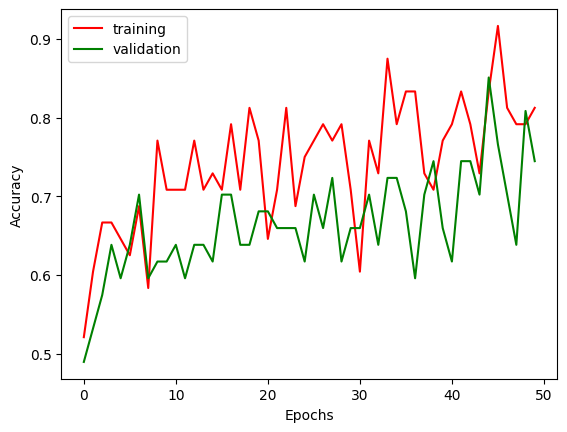

In [24]:
make_figure(training_acc_EEGNet, validation_acc_EEGNet, name = "EEGNet2")

In [25]:
###################################################################################
## No (3) Training and Test The EEGNet ############################################
###################################################################################
eegnet = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eegnet.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eegnet = {
    "x_train": x_train_sub_1_EEG,
    "y_train": y_train_sub_1_EEG,
    "x_valid": x_valid_sub_1_EEG,
    "y_valid": y_valid_sub_1_EEG
}
training_acc_EEGNet, validation_acc_EEGNet = train_model(data_eegnet, optimizer, criterion, eegnet, batch_size, num_epoch)
start_time = time.time()
test_model(eegnet, model_choice="EEGNet", X_test=X_test_subject_1, y_test=y_test_subject_1)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out_features=

  4%|▍         | 2/50 [00:00<00:04, 10.96it/s]

Epoch:  1
[1, 3] loss: 1.426
[1, 6] loss: 1.358
[1, 9] loss: 1.331
[1, 12] loss: 1.326
Validation Accuracy: 0.27659574151039124
Epoch:  2
[2, 3] loss: 1.258
[2, 6] loss: 1.242
[2, 9] loss: 1.211
[2, 12] loss: 1.207
Validation Accuracy: 0.27659574151039124
Epoch:  3


  8%|▊         | 4/50 [00:00<00:04, 10.63it/s]

[3, 3] loss: 1.128
[3, 6] loss: 1.168
[3, 9] loss: 1.120
[3, 12] loss: 1.134
Validation Accuracy: 0.2978723347187042
Epoch:  4
[4, 3] loss: 1.057
[4, 6] loss: 1.035
[4, 9] loss: 1.047
[4, 12] loss: 1.068
Validation Accuracy: 0.2978723347187042
Epoch:  5
[5, 3] loss: 0.944


 12%|█▏        | 6/50 [00:00<00:04, 10.71it/s]

[5, 6] loss: 1.044
[5, 9] loss: 0.916
[5, 12] loss: 0.964
Validation Accuracy: 0.3404255211353302
Epoch:  6
[6, 3] loss: 0.900
[6, 6] loss: 0.886
[6, 9] loss: 0.885
[6, 12] loss: 0.891
Validation Accuracy: 0.40425530076026917
Epoch:  7
[7, 3] loss: 0.912
[7, 6] loss: 0.879


 16%|█▌        | 8/50 [00:00<00:03, 10.74it/s]

[7, 9] loss: 0.774
[7, 12] loss: 0.820
Validation Accuracy: 0.3191489279270172
Epoch:  8
[8, 3] loss: 0.768
[8, 6] loss: 0.767
[8, 9] loss: 0.771
[8, 12] loss: 0.778
Validation Accuracy: 0.3404255211353302
Epoch:  9
[9, 3] loss: 0.731
[9, 6] loss: 0.777
[9, 9] loss: 0.737


 20%|██        | 10/50 [00:00<00:03, 10.52it/s]

[9, 12] loss: 0.686
Validation Accuracy: 0.3404255211353302
Epoch:  10
[10, 3] loss: 0.727
[10, 6] loss: 0.644
[10, 9] loss: 0.679
[10, 12] loss: 0.670
Validation Accuracy: 0.3404255211353302
Epoch:  11
[11, 3] loss: 0.644
[11, 6] loss: 0.667
[11, 9] loss: 0.603
[11, 12] loss: 0.642
Validation Accuracy: 0.3191489279270172
Epoch:  12


 24%|██▍       | 12/50 [00:01<00:03, 10.56it/s]

[12, 3] loss: 0.597
[12, 6] loss: 0.622
[12, 9] loss: 0.621
[12, 12] loss: 0.568
Validation Accuracy: 0.3404255211353302
Epoch:  13
[13, 3] loss: 0.584
[13, 6] loss: 0.540
[13, 9] loss: 0.575
[13, 12] loss: 0.533
Validation Accuracy: 0.3617021143436432
Epoch:  14
[14, 3] loss: 0.551


 28%|██▊       | 14/50 [00:01<00:03, 10.50it/s]

[14, 6] loss: 0.477
[14, 9] loss: 0.521
[14, 12] loss: 0.553
Validation Accuracy: 0.3617021143436432
Epoch:  15
[15, 3] loss: 0.494
[15, 6] loss: 0.537
[15, 9] loss: 0.431
[15, 12] loss: 0.465
Validation Accuracy: 0.3191489279270172
Epoch:  16
[16, 3] loss: 0.453
[16, 6] loss: 0.456


 32%|███▏      | 16/50 [00:01<00:03, 10.52it/s]

[16, 9] loss: 0.467
[16, 12] loss: 0.425
Validation Accuracy: 0.3617021143436432
Epoch:  17
[17, 3] loss: 0.456
[17, 6] loss: 0.391
[17, 9] loss: 0.431
[17, 12] loss: 0.390
Validation Accuracy: 0.3617021143436432
Epoch:  18
[18, 3] loss: 0.438
[18, 6] loss: 0.420
[18, 9] loss: 0.378


 40%|████      | 20/50 [00:01<00:02, 10.58it/s]

[18, 12] loss: 0.365
Validation Accuracy: 0.3404255211353302
Epoch:  19
[19, 3] loss: 0.480
[19, 6] loss: 0.362
[19, 9] loss: 0.359
[19, 12] loss: 0.318
Validation Accuracy: 0.3617021143436432
Epoch:  20
[20, 3] loss: 0.355
[20, 6] loss: 0.347
[20, 9] loss: 0.336
[20, 12] loss: 0.341
Validation Accuracy: 0.40425530076026917
Epoch:  21


 44%|████▍     | 22/50 [00:02<00:02, 10.63it/s]

[21, 3] loss: 0.343
[21, 6] loss: 0.331
[21, 9] loss: 0.311
[21, 12] loss: 0.371
Validation Accuracy: 0.40425530076026917
Epoch:  22
[22, 3] loss: 0.291
[22, 6] loss: 0.278
[22, 9] loss: 0.356
[22, 12] loss: 0.262
Validation Accuracy: 0.3829787075519562
Epoch:  23
[23, 3] loss: 0.303


 48%|████▊     | 24/50 [00:02<00:02, 10.66it/s]

[23, 6] loss: 0.290
[23, 9] loss: 0.279
[23, 12] loss: 0.310
Validation Accuracy: 0.3829787075519562
Epoch:  24
[24, 3] loss: 0.277
[24, 6] loss: 0.300
[24, 9] loss: 0.335
[24, 12] loss: 0.303
Validation Accuracy: 0.3829787075519562
Epoch:  25
[25, 3] loss: 0.266
[25, 6] loss: 0.312


 52%|█████▏    | 26/50 [00:02<00:02, 10.71it/s]

[25, 9] loss: 0.253
[25, 12] loss: 0.271
Validation Accuracy: 0.46808508038520813
Epoch:  26
[26, 3] loss: 0.271
[26, 6] loss: 0.264
[26, 9] loss: 0.266
[26, 12] loss: 0.281
Validation Accuracy: 0.40425530076026917
Epoch:  27
[27, 3] loss: 0.247
[27, 6] loss: 0.233
[27, 9] loss: 0.318


 56%|█████▌    | 28/50 [00:02<00:02, 10.74it/s]

[27, 12] loss: 0.211
Validation Accuracy: 0.40425530076026917
Epoch:  28
[28, 3] loss: 0.232
[28, 6] loss: 0.234
[28, 9] loss: 0.250
[28, 12] loss: 0.203
Validation Accuracy: 0.3829787075519562
Epoch:  29
[29, 3] loss: 0.232
[29, 6] loss: 0.222
[29, 9] loss: 0.209
[29, 12] loss: 0.243
Validation Accuracy: 0.40425530076026917
Epoch:  30


 60%|██████    | 30/50 [00:02<00:01, 10.78it/s]

[30, 3] loss: 0.200
[30, 6] loss: 0.230
[30, 9] loss: 0.222
[30, 12] loss: 0.262
Validation Accuracy: 0.42553189396858215
Epoch:  31
[31, 3] loss: 0.185
[31, 6] loss: 0.217
[31, 9] loss: 0.189
[31, 12] loss: 0.204
Validation Accuracy: 0.44680848717689514
Epoch:  32
[32, 3] loss: 0.196


 64%|██████▍   | 32/50 [00:03<00:01, 10.77it/s]

[32, 6] loss: 0.175
[32, 9] loss: 0.205
[32, 12] loss: 0.209
Validation Accuracy: 0.42553189396858215
Epoch:  33
[33, 3] loss: 0.152
[33, 6] loss: 0.198
[33, 9] loss: 0.186
[33, 12] loss: 0.167
Validation Accuracy: 0.3829787075519562
Epoch:  34
[34, 3] loss: 0.172
[34, 6] loss: 0.185


 68%|██████▊   | 34/50 [00:03<00:01, 10.79it/s]

[34, 9] loss: 0.160
[34, 12] loss: 0.175
Validation Accuracy: 0.42553189396858215
Epoch:  35
[35, 3] loss: 0.189
[35, 6] loss: 0.164
[35, 9] loss: 0.187
[35, 12] loss: 0.179
Validation Accuracy: 0.44680848717689514
Epoch:  36
[36, 3] loss: 0.206
[36, 6] loss: 0.166
[36, 9] loss: 0.196


 76%|███████▌  | 38/50 [00:03<00:01, 10.86it/s]

[36, 12] loss: 0.162
Validation Accuracy: 0.46808508038520813
Epoch:  37
[37, 3] loss: 0.131
[37, 6] loss: 0.177
[37, 9] loss: 0.163
[37, 12] loss: 0.171
Validation Accuracy: 0.42553189396858215
Epoch:  38
[38, 3] loss: 0.138
[38, 6] loss: 0.123
[38, 9] loss: 0.133
[38, 12] loss: 0.156
Validation Accuracy: 0.44680848717689514
Epoch:  39


 80%|████████  | 40/50 [00:03<00:00, 10.87it/s]

[39, 3] loss: 0.147
[39, 6] loss: 0.131
[39, 9] loss: 0.143
[39, 12] loss: 0.136
Validation Accuracy: 0.3617021143436432
Epoch:  40
[40, 3] loss: 0.141
[40, 6] loss: 0.156
[40, 9] loss: 0.153
[40, 12] loss: 0.126
Validation Accuracy: 0.40425530076026917
Epoch:  41
[41, 3] loss: 0.133


 84%|████████▍ | 42/50 [00:03<00:00, 10.84it/s]

[41, 6] loss: 0.172
[41, 9] loss: 0.136
[41, 12] loss: 0.104
Validation Accuracy: 0.4893616735935211
Epoch:  42
[42, 3] loss: 0.122
[42, 6] loss: 0.139
[42, 9] loss: 0.123
[42, 12] loss: 0.121
Validation Accuracy: 0.42553189396858215
Epoch:  43
[43, 3] loss: 0.146
[43, 6] loss: 0.145


 88%|████████▊ | 44/50 [00:04<00:00, 10.86it/s]

[43, 9] loss: 0.110
[43, 12] loss: 0.138
Validation Accuracy: 0.40425530076026917
Epoch:  44
[44, 3] loss: 0.127
[44, 6] loss: 0.122
[44, 9] loss: 0.123
[44, 12] loss: 0.133
Validation Accuracy: 0.40425530076026917
Epoch:  45
[45, 3] loss: 0.095
[45, 6] loss: 0.113
[45, 9] loss: 0.155


 92%|█████████▏| 46/50 [00:04<00:00, 10.86it/s]

[45, 12] loss: 0.119
Validation Accuracy: 0.40425530076026917
Epoch:  46
[46, 3] loss: 0.107
[46, 6] loss: 0.118
[46, 9] loss: 0.122
[46, 12] loss: 0.126
Validation Accuracy: 0.40425530076026917
Epoch:  47
[47, 3] loss: 0.145
[47, 6] loss: 0.114
[47, 9] loss: 0.127
[47, 12] loss: 0.093
Validation Accuracy: 0.44680848717689514
Epoch:  48


 96%|█████████▌| 48/50 [00:04<00:00, 10.84it/s]

[48, 3] loss: 0.132
[48, 6] loss: 0.142
[48, 9] loss: 0.151
[48, 12] loss: 0.107
Validation Accuracy: 0.44680848717689514
Epoch:  49
[49, 3] loss: 0.094
[49, 6] loss: 0.119
[49, 9] loss: 0.150
[49, 12] loss: 0.142
Validation Accuracy: 0.46808508038520813
Epoch:  50
[50, 3] loss: 0.102


100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


[50, 6] loss: 0.096
[50, 9] loss: 0.122
[50, 12] loss: 0.081
Validation Accuracy: 0.44680848717689514
Finish Training
Test accuracy for  EEGNet is:  0.44
Time To Run:  0.025492429733276367 seconds


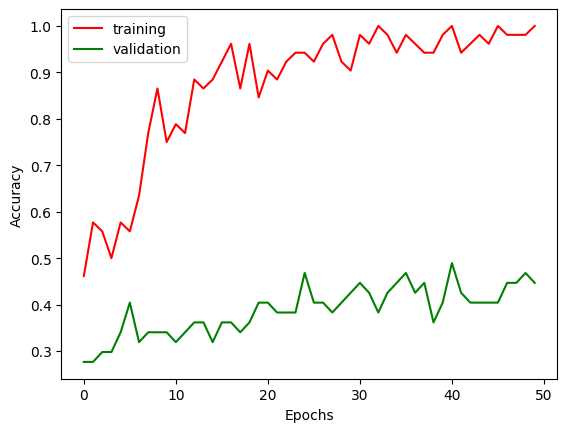

In [26]:
make_figure(training_acc_EEGNet, validation_acc_EEGNet, name = "EEGNet3")